<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hierarchical-Quick-Shift-(HQuickSHIFT)" data-toc-modified-id="Hierarchical-Quick-Shift-(HQuickSHIFT)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hierarchical Quick Shift (HQuickSHIFT)</a></span><ul class="toc-item"><li><span><a href="#Prepare-Dataset-for-RNN" data-toc-modified-id="Prepare-Dataset-for-RNN-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prepare Dataset for RNN</a></span></li><li><span><a href="#Recurrent-Neural-Network-(RNN)" data-toc-modified-id="Recurrent-Neural-Network-(RNN)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Recurrent Neural Network (RNN)</a></span><ul class="toc-item"><li><span><a href="#Train-a-RNN-from-Scratch" data-toc-modified-id="Train-a-RNN-from-Scratch-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Train a RNN from Scratch</a></span></li><li><span><a href="#Load-a-RNN-model-already-trained" data-toc-modified-id="Load-a-RNN-model-already-trained-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Load a RNN model already trained</a></span></li></ul></li></ul></li><li><span><a href="#Sklearn-Benchmarks" data-toc-modified-id="Sklearn-Benchmarks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sklearn Benchmarks</a></span></li><li><span><a href="#Real-Dataset-Benchmarks" data-toc-modified-id="Real-Dataset-Benchmarks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Real Dataset Benchmarks</a></span><ul class="toc-item"><li><span><a href="#Collect-and-Plot-Batch-Run-Results" data-toc-modified-id="Collect-and-Plot-Batch-Run-Results-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Collect and Plot Batch Run Results</a></span></li><li><span><a href="#Quick-Test" data-toc-modified-id="Quick-Test-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Quick Test</a></span><ul class="toc-item"><li><span><a href="#HDBSCAN" data-toc-modified-id="HDBSCAN-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>HDBSCAN</a></span></li><li><span><a href="#Quickshift++" data-toc-modified-id="Quickshift++-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Quickshift++</a></span></li><li><span><a href="#HQSHIFT" data-toc-modified-id="HQSHIFT-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>HQSHIFT</a></span></li></ul></li><li><span><a href="#RNN-Training-Part" data-toc-modified-id="RNN-Training-Part-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RNN Training Part</a></span><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li></ul></li></ul></li></ul></div>

# Hierarchical Quick Shift (HQuickSHIFT)

Export the external libraries first. We also define the plotting and random initialization functions and global variables.  

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import sys
import seaborn as sns
import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import sklearn.datasets as data
import sklearn.cluster as cluster
import hdbscan
from QuickshiftPP import *
from MedoidShift_and_QuickShift.quick_shift_ import QuickShift
import networkx as nx
from mlpack import emst
from mlpack import fastmks
import umap

import torch
import fastai
from fastai.utils import *
from fastai.core import *
from fastai.text import *

USE_GPU = True
dtype = torch.float32
use_cuda = torch.cuda.is_available()
if USE_GPU and use_cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

# For reproducibility: origin of the randomness during training 
seed = 1234
seed_lst = [0, 23, 42, 1234, 43210, 1133557799, 22446688, 123456789, 987654321, 86420]
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
random_seed(seed_value=seed, use_cuda=use_cuda)

# suppress scientific float notation
np.set_printoptions(precision=6, suppress=True)
# filter out informational none critical warnings
import warnings
# matplotlib warnings are subclass of UserWarning
warnings.simplefilter("ignore", category=UserWarning)

fig_size = (20, 16)
plot_kwds = {'alpha' : 1, 's' : 40, 'linewidths':0}
def plot_clusters(data, labels=None, algorithm=None, args=None, kwds=None, plt_title=None, file_name=None):
    plt.figure(figsize=fig_size)
    if algorithm is not None:
        if algorithm.__name__=='QuickshiftPP':
            model = algorithm(**kwds)
            model.fit(data)
            labels = model.memberships
        else:
            labels = algorithm(*args, **kwds).fit_predict(data)   
        max_n_labels = np.maximum(8, np.unique(labels).max() + 1)
#         import pdb;pdb.set_trace()
        palette = sns.hls_palette(max_n_labels, l=.3, s=.8) 
        node_color = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
#         plt.title('Clusters found by {} and the number of Clusters: {:d}'.format(\
#                  str(algorithm.__name__), np.unique(labels).max() + 1), fontsize=28)
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.setp(plt.gca().get_yticklabels(), visible=False)
        plt.tight_layout()
    else:
        if labels is not None:
            max_n_labels = np.maximum(8, np.unique(labels).max() + 1)
            palette = sns.hls_palette(max_n_labels, l=.3, s=.8) 
            node_color = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
        else:
            node_color = ['b']      
    plt.scatter(data.T[0], data.T[1], c=node_color, **plot_kwds)
#     plt.setp(plt.gca().get_xticklabels(), visible=False)
#     plt.setp(plt.gca().get_yticklabels(), visible=False)
    plt.tight_layout()
#     if plt_title is not None: plt.title(plt_title)
    if file_name is not None: plt.savefig(file_name, dpi=200, bbox_inches='tight')

using device: cuda


It is a good habit to list the version of the libraries to reproduce the results and check their correct installation. An additional **environment.yml** file is also provided for this purpose under the provided folder.

You can create a new environment:
+ conda env create -f environment.yml

In [14]:
print("Numpy version:   %s" %(np.__version__))
print("Sklearn version: %s" %(sklearn.__version__))
print("PyTorch version: %s" %(torch.__version__))
print("Fastai version:  %s" %(fastai.__version__))
print("Umap version:    %s" %(umap.__version__))

Numpy version:   1.16.4
Sklearn version: 0.21.2
PyTorch version: 1.1.0
Fastai version:  1.0.46
Umap version:    0.3.9


**EuclideanMinimumSpanningTree** class to estimate the bandwidth in the scope of Hierarchical Quick Shift (HQuickSHIFT): 

In [15]:
class EuclideanMinimumSpanningTree(object):
    """Build  Euclidean MinimumSpanning Tree with MLpack's 
    Euclidian minimum spanning tree (emst) routine. 
    
    Parameters
    ----------
    data: float, required 
        Array of input data shape (n_samples, n_features)
    copy_all_inputs: bool, optional (default=True)
        Params for MLpack's Euclidian minimum spanning tree (emst) and 
        Fast Max-Kernel Search (FastMKS).
        If specified, all input parameters will be deep copied before the method 
        is run. This is useful for debugging problems where the input parameters 
        are being modified by the algorithm, but can slow down the code.
    verbose: bool, optional (default=False)
        Params for MLpack's Euclidian minimum spanning tree (emst).
        Display informational messages and the full list of parameters and 
        timers at the end of execution.
    leaf_size: int, optional (default=20)
        Leaf size in the kd-tree built by MLpack's Euclidian minimum spanning 
        tree (emst) routine. One-element leaves give the empirically best 
        performance, but at the cost of greater memory requirements.
    """
    def __init__(self, data, copy_all_inputs=True, verbose=False, leaf_size=20):
        self._data = data
        self._copy_all_inputs = copy_all_inputs
        self._verbose = verbose
        self._leaf_size = leaf_size
        self._construct_graph()

    def _construct_graph(self):
        self._emst = emst(input=self._data, copy_all_inputs=self._copy_all_inputs,
                         verbose=self._verbose, leaf_size=self._leaf_size)['output']
        self._bandwidth = (np.mean(self._emst[:,2]))**(1/self._data.shape[1])
                   
    def plot(self, axis=None, with_labels=False, node_size=40,
             node_color='k', edge_cmap=plt.cm.viridis, edge_width=2, colorbar=True):
        """Plot the minimum spanning tree (as projected into 2D by UMAP if required).
        Parameters
        ----------
        axis: matplotlib axis, optional (default=None)
               The axis to render the plot to
        with_labels: bool, optional (default=False)
               Set to True to draw labels on the nodes.
        node_size: int, optional (default 40)
                The size of nodes in the plot.
        node_color: matplotlib color spec, optional (default black)
                The color to render nodes.
        edge_cmap: matplotlib colormap, optional (default plt.cm.viridis)
                The colormap to color edges by (varying color by edge weight/distance). 
                Can be a cmap object.
        edge_width: float, optional (default 2)
                The linewidth to use for rendering edges.
        colorbar: bool, optional (default True)
                Whether to draw a colorbar.
        Returns
        -------
        axis : matplotlib axis
                The axis used the render the plot.
        """
        self._G = nx.Graph()
        for row in self._emst:
            self._G.add_edge(row[0], row[1], weight=row[2])
        data_dict = {index: tuple(row) for index, row in enumerate(self._data)}
        nx.set_node_attributes(self._G, data_dict, 'node_pos')
        if axis is None:
            axis = plt.gca()
        _, edge_weight = zip(*nx.get_edge_attributes(self._G,'weight').items())
        node_pos = nx.get_node_attributes(self._G, 'node_pos')
        edge_vmin =  0.0; edge_vmax = max(edge_weight)
        nx.draw_networkx(self._G, ax=axis, pos=node_pos, 
                         with_labels=with_labels, node_size=node_size, node_color=node_color,
                         width=edge_width, edge_color=edge_weight, edge_cmap=edge_cmap,
                         edge_vmin=edge_vmin, edge_vmax=edge_vmax) 
        if colorbar:
            sm = plt.cm.ScalarMappable(cmap=edge_cmap,
                                       norm=plt.Normalize(vmin=edge_vmin, vmax=edge_vmax))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axis)
            cbar.set_label('Euclidean distance', rotation=90)
#         plt.title('HQuickSHIFT Euclidean Minimum Spanning Tree, bandwidth: {:.2f}'.format(\
#                   self._bandwidth), fontsize=28)
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.setp(plt.gca().get_yticklabels(), visible=False)
        plt.tight_layout()
        return axis
    
    @property
    def bandwidth(self):
        return self._bandwidth 
    
    @property
    def emst_graph(self):
        return self._emst  

**MutualReachabilityMinimumSpanningTree** class is used to determine density connected modes in the scope of Hierarchical Quick Shift (HQuickSHIFT): 

In [16]:
from hdbscan.hdbscan_ import _hdbscan_boruvka_balltree, _hdbscan_boruvka_kdtree
class MutualReachabilityMinimumSpanningTree(object):
    """Build  Mutual Reachability MinimumSpanning Tree with HDBSCAN
    Compute the internal minimum spanning tree given a data matrix 
    
    Parameters
    ----------
    data: float, required 
        Array of input data shape (n_samples, n_features)
    min_samples : int, optional (default=5)
        The number of samples in a neighborhood for a point (k-nn)
        to be considered as a core point. This includes the point itself.
    leaf_size: int, optional (default=20)
        Leaf size in the ball tree built by HDBSCAN.
    """
    def __init__(self, data, min_samples=5, leaf_size=20):
        self._data = data
        self._min_samples = min_samples
        self._leaf_size = leaf_size
        self._construct_graph()

    def _construct_graph(self):
        (_, self._mrmst) = (_hdbscan_boruvka_balltree(self._data,
                                                      min_samples=self._min_samples,
                                                      leaf_size=self._leaf_size,
                                                      gen_min_span_tree=True))
                   
    def plot(self, axis=None, with_labels=False, node_size=40,
             node_color='k', edge_cmap=plt.cm.viridis, edge_width=2, colorbar=True):
        """Plot the minimum spanning tree (as projected into 2D by UMAP if required).
        Parameters
        ----------
        axis: matplotlib axis, optional (default=None)
               The axis to render the plot to
        with_labels: bool, optional (default=False)
               Set to True to draw labels on the nodes.
        node_size: int, optional (default 40)
                The size of nodes in the plot.
        node_color: matplotlib color spec, optional (default black)
                The color to render nodes.
        edge_cmap: matplotlib colormap, optional (default plt.cm.viridis)
                The colormap to color edges by (varying color by edge weight/distance). 
                Can be a cmap object.
        edge_width: float, optional (default 2)
                The linewidth to use for rendering edges.
        colorbar: bool, optional (default True)
                Whether to draw a colorbar.
        Returns
        -------
        axis : matplotlib axis
                The axis used the render the plot.
        """
        self._G = nx.Graph()
        for row in self._mrmst:
            self._G.add_edge(row[0], row[1], weight=row[2])
        data_dict = {index: tuple(row) for index, row in enumerate(self._data)}
        nx.set_node_attributes(self._G, data_dict, 'node_pos')
        if axis is None:
            axis = plt.gca()
        _, edge_weight = zip(*nx.get_edge_attributes(self._G,'weight').items())
        node_pos = nx.get_node_attributes(self._G, 'node_pos')
        edge_vmin =  0.0; edge_vmax = max(edge_weight)
        nx.draw_networkx(self._G, ax=axis, pos=node_pos, 
                         with_labels=with_labels, node_size=node_size, node_color=node_color,
                         width=edge_width, edge_color=edge_weight, edge_cmap=edge_cmap,
                         edge_vmin=edge_vmin, edge_vmax=edge_vmax) 
        if colorbar:
            sm = plt.cm.ScalarMappable(cmap=edge_cmap,
                                       norm=plt.Normalize(vmin=edge_vmin, vmax=edge_vmax))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axis)
            cbar.set_label('mutual reachability distance', rotation=90)
#         plt.title('Mutual Reachability Minimum Spanning Tree', fontsize=28)
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.setp(plt.gca().get_yticklabels(), visible=False)
        plt.tight_layout()
        return axis

    @property
    def mrmst_graph(self):
        return self._mrmst  

**HQSHIFT** is the main work horse and the implementation of the Hierarchical Quick Shift algorithm:

In [17]:
from sklearn.base import BaseEstimator, ClusterMixin
from hdbscan.hdbscan_ import _tree_to_labels
from hdbscan.plots import CondensedTree, SingleLinkageTree
from hdbscan._hdbscan_linkage import label
from scipy.sparse import csgraph, csr_matrix
from scipy.spatial import ConvexHull
     
def _find_nth_smallest(a, n):
    return np.partition(a, n-1)[n-1]

def rbf_kernel(d,bw): return np.exp(-d**2/(2*bw**2))

def _extract_weight(elem):  return elem[2]['weight']

# Inherits from sklearn
class HQSHIFT(BaseEstimator, ClusterMixin):
    """Perform HQSHIFT clustering from vector array.

    HQSHIFT - Hierarchical Quick Shift
    Performs quick  shift over varying tau values and determines
    the result to find a clustering that gives the best stability.
    This allows HQSHIFT to find clusters of varying tau(s) and be 
    more robust to parameter selection.
    
    Some of the listed "Parameters" and "Attributes" are ussed 
    in the same manner as HDBSCAN. Differences are stated explicitly.
    
    Parameters
    ----------
    copy_all_inputs: bool, optional (default=True)
        Params for MLpack's Euclidian minimum spanning tree (emst) and 
        Fast Max-Kernel Search (FastMKS).
        If specified, all input parameters will be deep copied before the method 
        is run. This is useful for debugging problems where the input parameters 
        are being modified by the algorithm, but can slow down the code.
    verbose: bool, optional (default=False)
        Params for MLpack's Euclidian minimum spanning tree (emst) and 
        Fast Max-Kernel Search (FastMKS).
        Display informational messages and the full list of parameters and 
        timers at the end of execution.
    leaf_size: int, optional (default=20)
        Leaf size in the kd-tree built by MLpack's Euclidian minimum spanning 
        tree (emst) routine. One-element leaves give the empirically best 
        performance, but at the cost of greater memory requirements.
    kernel: str, optional (default=‘gaussian’)
        Kernel type to use in FastMKS: ‘gaussian’, ‘epanechnikov’, ‘triangular’ or 'cosine'.
    base: float, optional (default=2.0)
        Base to use during cover tree construction for MLpack's FastMKS.
    min_mode_size : int, optional (default=12)
        The minimum size of modal-set; single linkage splits that contain
        fewer points than this will be considered points "falling out" of a
        modal-set rather than a modal-set splitting into two new modal-sets.
    min_cluster_size : int, optional (default=60) 
        The minimum size of clusters; single linkage splits that contain
        fewer points than this will be considered points "falling out" of a
        cluster rather than a cluster splitting into two new clusters.
    min_samples : int, optional (default=5)
        The number of samples in a neighborhood for a point (k-nn)
        to be considered as a core point. This includes the point itself.
    cluster_selection_method : string, optional (default='eom')
        The method used to select clusters from the condensed tree. Similar to 
        the HDBSCAN*, HQSHIFT uses an "Excess of Mass" algorithm to find the most 
        persistent clusters. Alternatively you can instead select the clusters 
        at the leaves of the tree -- this provides the most fine grained and 
        homogeneous clusters. Routines imported directly from HDBSCAN. 
        Options are:
            * ``eom``
            * ``leaf``
   allow_single_cluster : bool, optional (default=False)
        Similar to HDBSCAN*, HQSHIFT by default will not produce a single cluster, 
        setting this to True will override this and allow single cluster results in
        the case that you feel this is a valid result for your dataset.
        
    Attributes
    ----------
    labels_ : ndarray, shape (n_samples, )
        Cluster labels for each point in the dataset given to fit().
        Noisy samples are given the label -1.
    probabilities_ : ndarray, shape (n_samples, )
        Differing from HDBSCAN*, HQSHIFT estimates the probability density
        of each sample with FastMKS using different kernels. 
    cluster_persistence_ : ndarray, shape (n_clusters, )
        A score of how persistent each cluster is. A score of 1.0 represents
        a perfectly stable cluster that persists over all distance scales,
        while a score of 0.0 represents a perfectly ephemeral cluster. These
        scores can be guage the relative coherence of the clusters output
        by the algorithm.
    _condensed_tree : CondensedTree object
        The condensed tree produced by HDBSCAN. The object has methods
        for converting to pandas, networkx, and plotting.
    _single_linkage_tree : SingleLinkageTree object
        The single linkage tree produced by HDBSCAN. The object has methods
        for converting to pandas, networkx, and plotting.
    _emst : Euclidian MinimumSpanningTree object
        The euclidian minimum spanning tree  generated by HQSHIFT to estimate
        optimal kernel bandwidth. 
        
    References
    ----------
    .. [1] L. McInnes, J. Healy, S. Astels, hdbscan: Hierarchical density 
       based clustering In: Journal of Open Source Software, The Open Journal, 
       volume 2, number 11. 2017
    .. [2] Campello, R. J., Moulavi, D., & Sander, J. (2013, April).
       Density-based clustering based on hierarchical density estimates.
       In Pacific-Asia Conference on Knowledge Discovery and Data Mining
       (pp. 160-172). Springer Berlin Heidelberg.
    .. [3] Vedaldi A., Soatto S. (2008) Quick Shift and Kernel Methods for 
       Mode Seeking. In: Forsyth D., Torr P., Zisserman A. (eds) Computer Vision – ECCV 2008. 
       Lecture Notes in Computer Science, vol 5305. Springer, Berlin, Heidelberg.
    .. [4] March, William B. and Ram, Parikshit and Gray, Alexander G.
       Fast Euclidean minimum spanning tree: algorithm, analysis, and applications.
       Proceedings of the 16th ACM SIGKDD International Conference on Knowledge Discovery 
       and Data Mining (KDD '10), pp. 603-612, (2010), ACM
    .. [5] Curtin, Ryan R. and Ram, Parikshit and Gray, Alexander G. 
       Fast Exact Max-Kernel Search, Proceedings of the 2013 SIAM International Conference 
       on Data Mining (SDM '13), 2013, pp.1-9
    .. [6] Curtin, Ryan R. and Ram, Parikshit.
       Dual-tree fast exact max-kernel search, Statistical Analysis and Data Mining, vol 7,
       Wiley Subscription Services, Inc., A Wiley Company, pp. 229-253, 2014
    .. [7] Sreevani, C.A. Murthy.
       On bandwidth selection using minimal spanning tree for kernel density estimation,
       Computational Statistics and Data Analysis 102 (2016), pp.67–84
    """
    def __init__(self, copy_all_inputs=True, verbose=False,
                 leaf_size=20, kernel='gaussian', base=2.0,
                 min_cluster_size=60, min_mode_size=12, min_samples=5,
                 cluster_selection_method='eom', allow_single_cluster=False):
        self.copy_all_inputs = copy_all_inputs
        self.verbose = verbose
        self.leaf_size = leaf_size
        self.base = base
        self.kernel = kernel
        self.min_mode_size = min_mode_size
        self.min_cluster_size = min_cluster_size
        self.min_samples = min_samples
        self.cluster_selection_method = cluster_selection_method
        self.allow_single_cluster = allow_single_cluster
        
        self._emst = None
        self._mrmst = None
        self._condensed_tree = None
        self._single_linkage_tree = None
    
    def _compute_medoids(self, dist_matrix, weight_matrix=None):
        if weight_matrix is None:
            weight_matrix = rbf_kernel(d=dist_matrix, bw=self._emst._bandwidth)
        P = np.sum(weight_matrix, axis=0)
        prob = P
        P = P[:, None] - P
        dist_matrix[dist_matrix==0] = np.max(dist_matrix)/2
        S = np.sign(P) * (1/dist_matrix)
        medoids = np.argmax(S, axis=0)
        return medoids, prob
    
    def _quick_shift(self, data, dist_matrix, weight_matrix=None): 
        medoids,prob= self._compute_medoids(dist_matrix, weight_matrix)
        stationary_idx = []
        for i in range(len(medoids)):
            if medoids[i] == i:
                stationary_idx.append(i)
        cls_ctrs = data[stationary_idx]
        labels, traj_lst  = [],[]
        labels_val = {}
        lab = 0
        for i in stationary_idx:
            labels_val[i] = lab
            lab += 1
        for i in range(len(data)):
            next_med = medoids[i]
            traj = []
            while next_med not in stationary_idx:
                traj.append(next_med.item())
                next_med = medoids[next_med]
            traj.append(next_med.item())
            traj_lst.append(np.asarray(traj))
            labels.append(labels_val[next_med.item()])
        return cls_ctrs, np.asarray(labels), np.asarray(stationary_idx),\
               np.asarray(traj_lst), np.asarray(prob)  
    
    def _quick_shift_fastmks(self, data):
        # for each point in the query set, the k points in the reference set 
        # with maximum kernel evaluations are found
        output = fastmks(k=data.shape[0], reference=data, bandwidth=self._emst.bandwidth,
                         base=self.base, kernel=self.kernel,
                         copy_all_inputs=self.copy_all_inputs)
        indices = output['indices']
        kernels = output['kernels']
        indices[:,-1]=np.arange(indices.shape[0])
        sorted_indices = np.argsort(indices)
        kernel_srt = np.array([[kernels[ri, col]] for ri,row in enumerate(sorted_indices) 
                                                  for col in row]).reshape(indices.shape)
        #small_number = _find_nth_smallest(np.ravel(kernel_srt),indices.shape[0]+1)
        small_number = np.median(kernel_srt)
        np.fill_diagonal(kernel_srt, small_number)
        # return a pseudo distance as the inverse of evaluations (val) of kernels
        #dist_matrix = np.sqrt(-log(kernel_srt+np.finfo(float).eps)*self._emst.bandwidth)*self._emst.bandwidth
        dist_matrix = -log(kernel_srt+np.finfo(float).eps)*self._emst.bandwidth*self._emst.bandwidth
        return dist_matrix, kernel_srt
    
    def _construct_graph(self, X):
        dist_matrix, weight_matrix = self._quick_shift_fastmks(data=X)
        cls_ctrs, cls_labels, stat_idx, traj, prob =\
            self._quick_shift(data=X, dist_matrix=dist_matrix, weight_matrix=weight_matrix)
        self.paths = [path.tolist() for path in traj]
        # Hierarchical Quick Shift Tree
        visited = np.zeros(len(self.paths))
        self._hqst = []
        for i, pth in enumerate(self.paths):
            # no edges inserted between stationary node and itsef!
            if i != stat_idx[0]:
                # append the current node to the beginning of the path
                cpth = [i] + pth
                for j in np.arange(len(cpth)-1): 
                    self._hqst.append([cpth[j], cpth[j+1], dist_matrix[cpth[j], cpth[j+1]]])
        
        self._hqst = np.array(self._hqst)
        _hqst_sparse = csr_matrix((self._hqst.T[2], (self._hqst.T[0], self._hqst.T[1])),
                                  shape=dist_matrix.shape) 
        # Compute the minimum spanning tree for the sparse graph
        self._hqst_mst = csgraph.minimum_spanning_tree(_hqst_sparse)
        # Convert the graph to scipy cluster array format
        nonzeros = self._hqst_mst.nonzero()
        nonzero_vals = self._hqst_mst[nonzeros]
        self._hqst_mst = np.vstack(nonzeros + (nonzero_vals,)).T
        # Sort edges of the min_spanning_tree by weight
        self._hqst_mst = np.asarray(self._hqst_mst[np.argsort(self._hqst_mst.T[2]),:][0])
        # Perform single linkage Hierarchical Quick Shift Minimum Spanning Tree
        sltree = label(self._hqst_mst)
        (self.quick_shift_labels_, 
         self.quick_shift_probabilities_, 
         self.quick_shift_cluster_persistence, 
         self._quick_shift_condensed_tree, 
         self._quick_shift_single_linkage_tree) =\
        (_tree_to_labels(X=X, single_linkage_tree=sltree,
                         cluster_selection_method=self.cluster_selection_method,
                         allow_single_cluster=self.allow_single_cluster,
                         min_cluster_size=self.min_mode_size))
        self.find_idx_roots(X)
        # Perform single linkage Mutual Reachability Minimum Spanning Tree
        sltree = label(self._mrmst.mrmst_graph)
        (self.labels_, 
         self.probabilities_, 
         self.cluster_persistence, 
         self._condensed_tree, 
         self._single_linkage_tree) =\
        (_tree_to_labels(X=X, single_linkage_tree=sltree,
                         cluster_selection_method=self.cluster_selection_method,
                         allow_single_cluster=self.allow_single_cluster,
                         min_cluster_size=self.min_cluster_size))
    def hqshift(self, X):
        # sanity checks
        if self.leaf_size < 1:
            raise ValueError('leaf size shall be greater than 0')
        if self.kernel not in ['gaussian', 'epanechnikov', 'triangular', 'cosine']:
            raise ValueError('Invalid kernel: %s\n'
                             'Shall be one of: "gaussian", "epanechnikov", "triangular", "cosine"\n' )
        if type(self.min_samples) is not int or type(self.min_cluster_size) is not int:
            raise ValueError('Min samples and min cluster size must be integers!')
        if self.min_samples <= 0 or self.min_cluster_size <= 0:
            raise ValueError('min cluster size shall be positive integer')
        if self.cluster_selection_method not in ('eom', 'leaf'):
            raise ValueError('Invalid cluster selection method: %s\n'
                             'Shall be one of: "eom", "leaf"\n')

        # construct Euclidian Minimum Spanning Tree for bandwidth estimation 
        # bandwidth to use in FastMKS for Gaussian, Epanechnikov, and triangular kernels. 
        # this is the "spread" of the kernel.
        self._emst = EuclideanMinimumSpanningTree(data=X, copy_all_inputs=self.copy_all_inputs,
                                                  verbose=self.verbose, leaf_size=self.leaf_size)
        self._mrmst = MutualReachabilityMinimumSpanningTree(data=X, min_samples=self.min_samples,
                                                            leaf_size=self.leaf_size)
        self._construct_graph(X=X)
        
    def plot_mrmst(self, X, axis=None, with_labels=False, node_size=40, alpha=0.5):
        """Plot the mutual reachability minimum spanning tree with labels.
        
        Parameters
        ----------
        axis: matplotlib axis, optional (default=None)
               The axis to render the plot to
        with_labels: bool, optional (default=False)
               Set to True to draw labels on the nodes.
        node_size: int, optional (default 40)
                The size of nodes in the plot.
        alpha: float, the edge transparency (default 0.5)
        
        Returns
        -------
        axis : matplotlib axis
                The axis used the render the plot.
        """        
        self._G = nx.Graph()
        nodes = np.arange(X.shape[0])
        self._G.add_nodes_from(nodes)
        for row in self._mrmst.mrmst_graph:
            self._G.add_edge(row[0], row[1], weight=row[2])
        data_dict = {index: tuple(row) for index, row in enumerate(X)}
        nx.set_node_attributes(self._G, data_dict, 'node_pos')
        if axis is None:
            axis = plt.gca()
        node_pos = nx.get_node_attributes(self._G, 'node_pos')
        
        max_n_labels = np.maximum(8, np.unique(self.labels_).max() + 1)
        palette = sns.hls_palette(max_n_labels, l=.3, s=.8) 
        node_color = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in self.labels_]
        nx.draw_networkx(self._G, ax=axis, pos=node_pos, with_labels=False, alpha=alpha, 
                         node_color=node_color, node_size=node_size)
#         plt.title('HQuickSHIFT Mutual Reachability Graph, number of Clusters: {:d}'.format(\
#                   np.unique(self.labels_).max() + 1), fontsize=28)
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.setp(plt.gca().get_yticklabels(), visible=False)
        return axis
    
    def find_idx_roots(self, X):
        self._Di_G = nx.DiGraph()
        nodes = np.arange(X.shape[0])
        self._Di_G.add_nodes_from(nodes)
        for row in self._hqst_mst:
            self._Di_G.add_edge(row[0], row[1], weight=row[2])
        data_dict = {index: tuple(row) for index, row in enumerate(X)}

        total_n_clusters = np.max(self.quick_shift_labels_) + 1
        cluster_range = np.arange(-1, total_n_clusters)\
            if -1 in self.quick_shift_labels_ else np.arange(total_n_clusters) 
        # Find root node of each subcluster including noise with a node (out_degree==0)
        self._idx_root = []
        for idx_clst in cluster_range:
            sub_nodes = np.where(self.quick_shift_labels_==idx_clst)[0]
            sub_G = nx.DiGraph(self._Di_G.subgraph(sub_nodes))
            idx_subg_root = list(node for node, out_degree in sub_G.out_degree() 
                                 if out_degree == 0)[0]
            self._idx_root.append(idx_subg_root)
        
    def plot(self, X, axis=None, with_labels=False, node_size=40, alpha=0.5, 
             plot_edge=True, plot_hull=True, file_name=None):
        """Plot the hierarchical quick shift tree with labels.
        
        Parameters
        ----------
        axis: matplotlib axis, optional (default None)
               The axis to render the plot to
        with_labels: bool, optional (default False)
               Set to True to draw labels on the nodes.
        node_size: int, optional (default 40)
                The size of nodes in the plot.
        alpha: float, the edge transparency (default 0.5)
        plot_edge: bool, optional (default True)
        plot_hull: bool, optional (default True)
        
        Returns
        -------
        axis : matplotlib axis
                The axis used the render the plot.
        """        
        self._Di_G = nx.DiGraph()
        nodes = np.arange(X.shape[0])
        self._Di_G.add_nodes_from(nodes)
        for row in self._hqst_mst:
            self._Di_G.add_edge(row[0], row[1], weight=row[2])
        data_dict = {index: tuple(row) for index, row in enumerate(X)}
        nx.set_node_attributes(self._Di_G, data_dict, 'node_pos')
        if axis is None:
            axis = plt.gca()
        node_pos = nx.get_node_attributes(self._Di_G, 'node_pos')
        #palette = plt.cm.tab10(np.linspace(0, 1, np.unique(self.labels_).max() + 1))
        #palette = sns.color_palette('deep', np.unique(self.labels_).max() + 1)
        max_n_labels = np.maximum(8, np.unique(self.labels_).max() + 1)
        palette = sns.hls_palette(max_n_labels, l=.3, s=.8) 
        node_color = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in self.labels_]
        
        total_n_clusters = np.max(self.quick_shift_labels_) + 1
        cluster_range = np.arange(-1, total_n_clusters)\
            if -1 in self.quick_shift_labels_ else np.arange(total_n_clusters) 
        # Find root node of each subcluster including noise with a node (out_degree==0)
        self._idx_root = []
        for idx_clst in cluster_range:
            sub_nodes = np.where(self.quick_shift_labels_==idx_clst)[0]
            sub_G = nx.DiGraph(self._Di_G.subgraph(sub_nodes))
            idx_subg_root = list(node for node, out_degree in sub_G.out_degree() 
                                 if out_degree == 0)[0]
            axis.plot((X[idx_subg_root][0]), (X[idx_subg_root][1]), 'X', color='k', markersize=12)
            self._idx_root.append(idx_subg_root)
            if plot_hull:
                node_labels = self.labels_[sub_nodes]
                points=X[sub_nodes][node_labels!=-1]
                hull = ConvexHull(points)
                for simplex in hull.simplices:
                    axis.plot(points[simplex, 0], points[simplex, 1], 'k--')      
        #self._Di_G.remove_edges_from(list(self._Di_G.edges(_idx_root)))
        #edge_weights = list(nx.get_edge_attributes(self._Di_G,'weight').values())
        edge_weights = 2
        if not plot_edge:
            self._Di_G.remove_edges_from(list(self._Di_G.edges(nodes)))
        nx.draw_networkx(self._Di_G, ax=axis, pos=node_pos, with_labels=False, alpha=alpha,
                         node_color=node_color, node_size=node_size, width=edge_weights,
                         arrowsize=14, arrowstyle='->')
#         plt.title('HQSHIFT Mode Attraction Graph, # of Modes: {:d}, # of Clusters: {:d}'.format(\
#                   np.unique(self.quick_shift_labels_).max() + 1, np.unique(self.labels_).max() + 1),
#                   fontsize=28)
#         if X.shape[1] == 2:
#             plt.xlabel("$x_0$", fontsize=28)
#             plt.ylabel("$x_1$", fontsize=28, rotation=90)
        plt.setp(axis.get_xticklabels(), visible=False)
        plt.setp(axis.get_yticklabels(), visible=False)
        plt.tight_layout()
        if file_name is not None: plt.savefig(file_name, dpi=200, bbox_inches='tight')
        return axis

    def fit(self, X, y=None):
        """Perform HQSHIFT clustering from features.
        
        Parameters
        ----------
        X : array of shape (n_samples, n_features)

        Returns
        -------
        self : object
            Returns self
        """
        self.hqshift(X)
        return self
    
    def fit_predict(self, X, y=None):
        """Performs clustering on X and returns cluster labels.

        Parameters
        ----------
        X : array of shape (n_samples, n_features)

        Returns
        -------
        y : ndarray, shape (n_samples, )
            cluster labels
        """
        self.fit(X)
        return self.labels_
    
    @property
    def single_linkage_tree(self):
        if self._single_linkage_tree is not None:
            return SingleLinkageTree(self._single_linkage_tree)
        else:
            raise AttributeError('No single linkage tree was generated; try running fit'
                 ' first.')
    @property
    def condensed_tree(self):
        if self._condensed_tree is not None:
            return CondensedTree(self._condensed_tree,
                                 self.cluster_selection_method,
                                 self.allow_single_cluster)
        else:
            raise AttributeError('No condensed tree was generated; try running fit first.')
            
    @property
    def quick_shift_condensed_tree(self):
        if self._quick_shift_condensed_tree is not None:
            return CondensedTree(self._quick_shift_condensed_tree,
                                 self.cluster_selection_method,
                                 self.allow_single_cluster)
        else:
            raise AttributeError('No quickshift condensed tree was generated; try running fit first.')

With a working example, we can demonstrate the features of Hierarchical Quick Shift algorithm and its advantages over QuickshiftPP. First, we create a toy dataset:

## Prepare Dataset for RNN

In [18]:
n_samples=350
n_noise_pts = 600
add_uniform_noise = True

def generate_data(n_samples, add_uniform_noise=add_uniform_noise,
                  plot_data=True, plt_title=None, file_name=None):
    random_seed(seed_value=seed, use_cuda=use_cuda)
    moons, lbls_moons = data.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
    blobs, lbls_blobs = data.make_blobs(n_samples=n_samples, centers=[(-1.5, 3.0), (1.5, 3.0)],
                               cluster_std=[0.15, 0.25], random_state=seed)
    
    # shear angles
    theta = np.radians([30, -30, -30, 30])
    t = np.tan(theta)

    blob3, lbls_blob3 = data.make_blobs(n_samples=n_samples//3,
                                        centers=[(-0.95, 0.75)],
                                        cluster_std=[0.10], random_state=seed)
    shear_x = np.array(((1, 0), (t[0], 1))).T
    blob3 = blob3.dot(shear_x)
    
    blob4, lbls_blob4 = data.make_blobs(n_samples=n_samples//4,
                                         centers=[(0.95, 0.75)],
                                         cluster_std=[0.10], random_state=seed)
    shear_x = np.array(((1, 0), (t[1], 1))).T
    blob4 = blob4.dot(shear_x)
    
    blob5, lbls_blob5 = data.make_blobs(n_samples=n_samples//4,
                                         centers=[(0.15, 0.0)],
                                         cluster_std=[0.10], random_state=seed)
    shear_x = np.array(((1, t[2]), (0, 1))).T
    blob5 = blob5.dot(shear_x)
    
    blob6, lbls_blob6 = data.make_blobs(n_samples=n_samples//3,
                                         centers=[(1.85, 0.0)],
                                         cluster_std=[0.10], random_state=seed)
    shear_x = np.array(((1, t[3]), (0, 1))).T
    blob6 = blob6.dot(shear_x)
        
    #import pdb;pdb.set_trace()
    
    test_data = np.vstack([moons, blobs, blob3, blob4, blob5, blob6])
    test_data_lbls = np.hstack([lbls_moons, lbls_blobs+2,
                                lbls_blob3+4, lbls_blob4+5, lbls_blob5+6, lbls_blob6+7])

    if add_uniform_noise:
        assert(test_data.shape[1]==2)
        (min0, min1), (max_0, max_1) = np.min(test_data, axis=0), np.max(test_data, axis=0)
        noise_data = np.random.RandomState(seed).uniform([min0, min1],[max_0, max_1], size=(n_noise_pts, 2))
        noise_lbls = np.array([-1]*n_noise_pts)
        test_data = np.vstack([test_data, noise_data])
        test_data_lbls = np.hstack([test_data_lbls, noise_lbls])
  
    test_data = shuffle(test_data, random_state=seed)
    test_data_lbls = shuffle(test_data_lbls, random_state=seed)
    # normalize dataset for easier parameter selection
    test_data_std = StandardScaler().fit_transform(test_data)
    #test_data_std = test_data
    #import pdb;pdb.set_trace()
    if plot_data:
        plot_clusters(data=test_data_std, labels=test_data_lbls,
                      file_name=file_name, plt_title=plt_title)
    return test_data_std

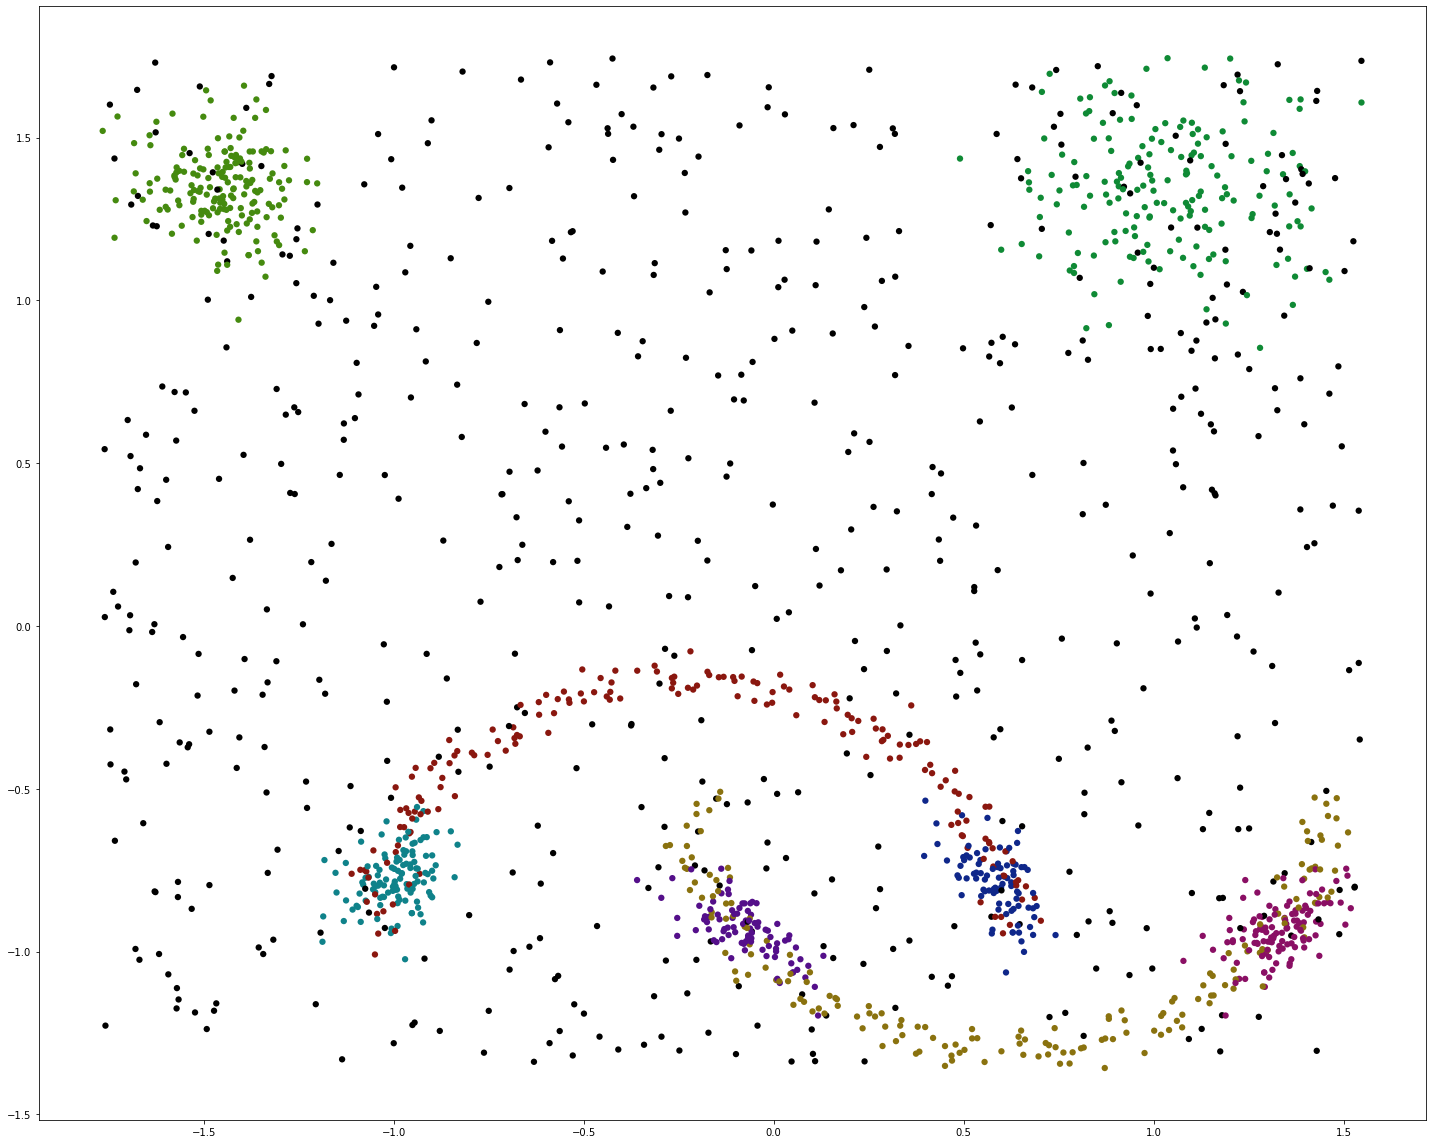

In [19]:
test_data = generate_data(n_samples=n_samples, add_uniform_noise=True,
                          file_name='blob_moon_dataset.png')
curaxes = plt.gca()
ax_xlim = curaxes.get_xlim()
ax_ylim = curaxes.get_ylim()

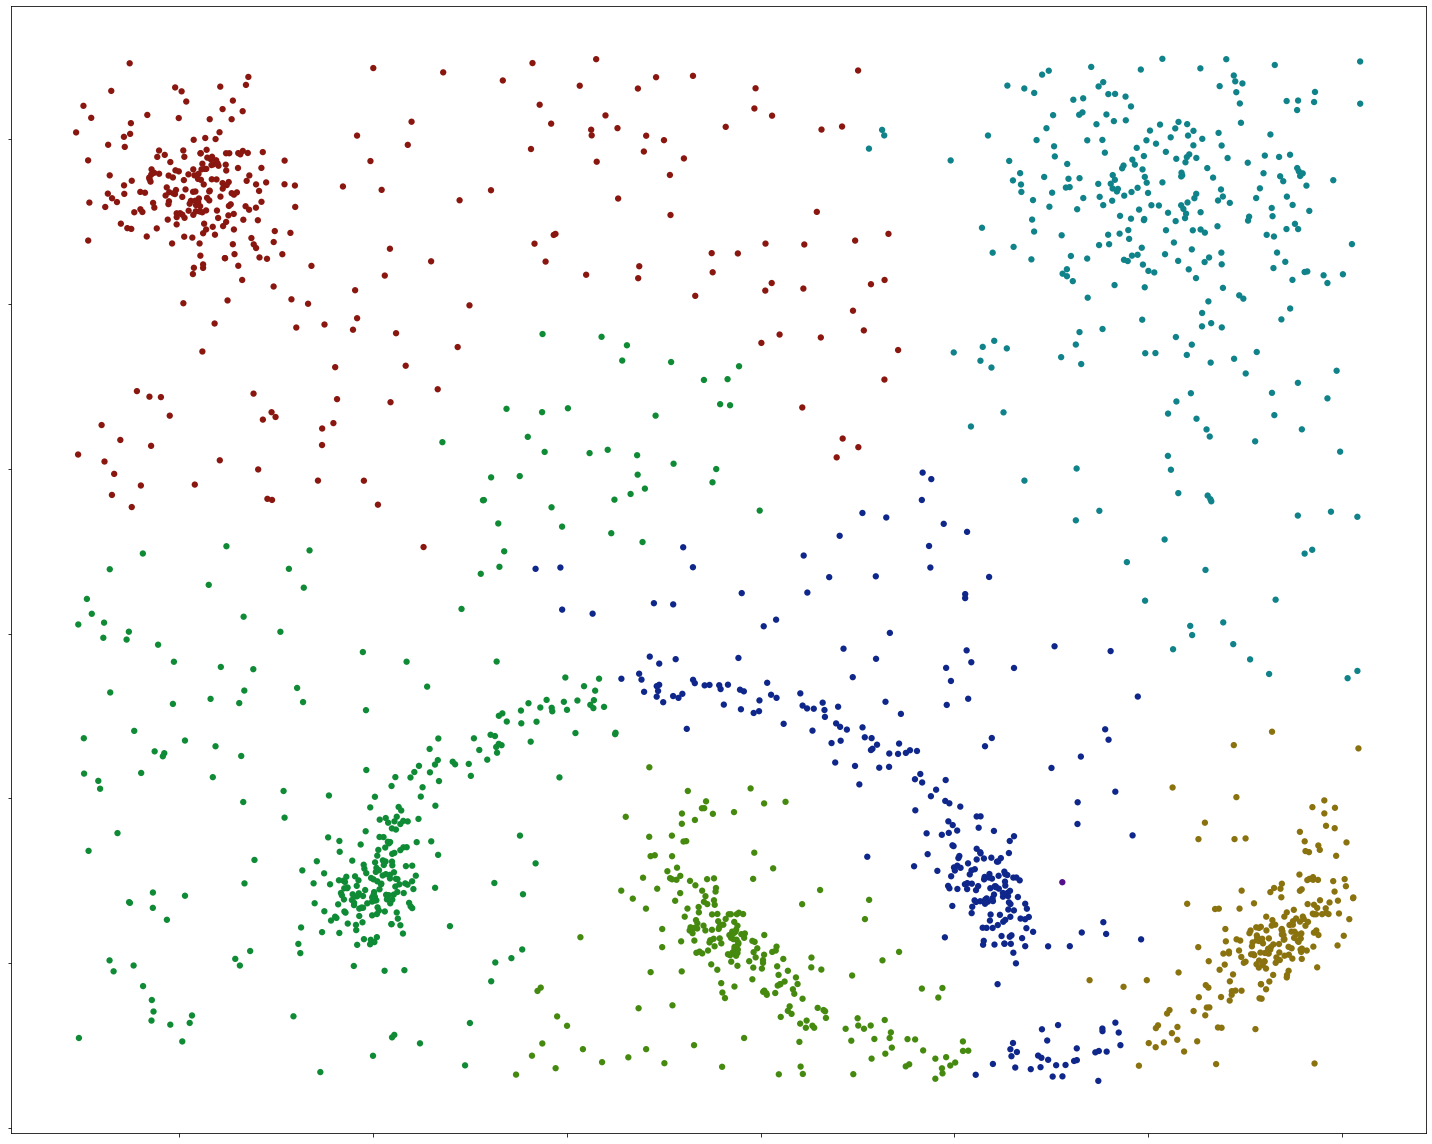

In [20]:
from QuickshiftPP import *
plot_clusters(data=test_data, algorithm=QuickshiftPP,
              args=(), kwds={'k':20, 'beta':.7}, file_name='blob_moon_qspp.png')
curaxes = plt.gca()
curaxes.set_xlim(ax_xlim)
curaxes.set_ylim(ax_ylim)
plt.show()

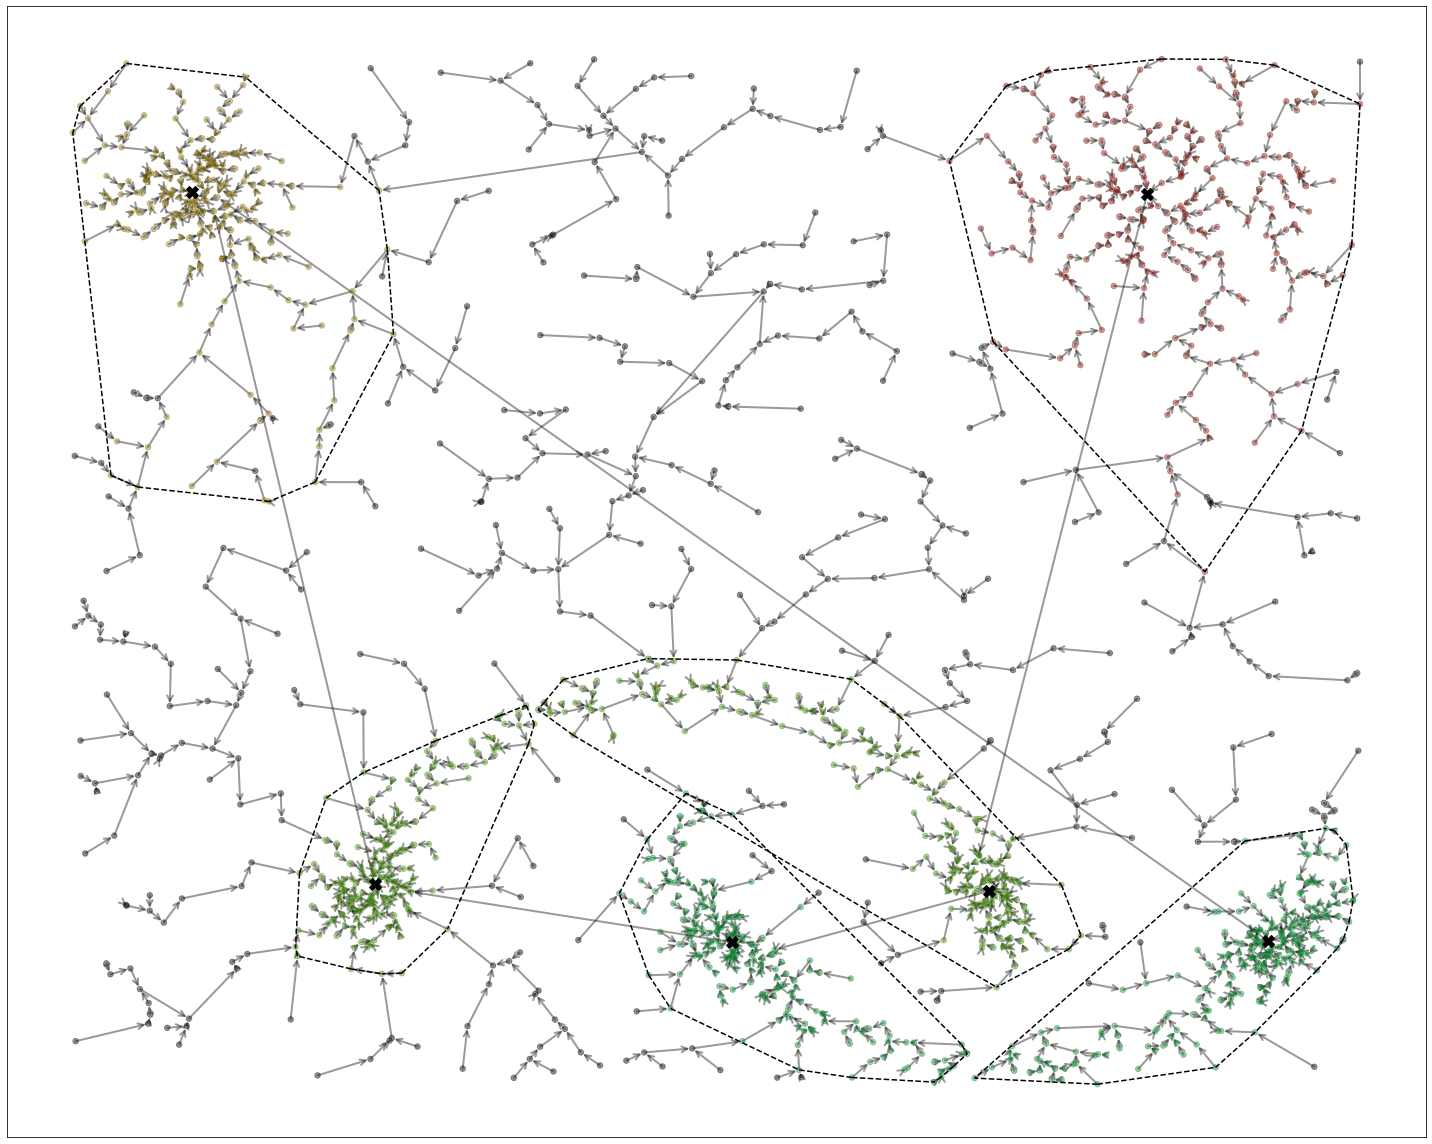

In [21]:
hqshift = HQSHIFT(min_cluster_size=125,
                  min_mode_size=150,
                  min_samples=15,
                  allow_single_cluster=False).fit(test_data)
plt.figure(figsize=fig_size)
curaxes = plt.gca()
curaxes.set_xlim(ax_xlim)
curaxes.set_ylim(ax_ylim)
hqshift.plot(test_data, plot_edge=True, plot_hull=True, node_size=30, alpha=0.4,
             file_name='blob_moon_hqshift.png')
plt.show()

0.20421907202880743


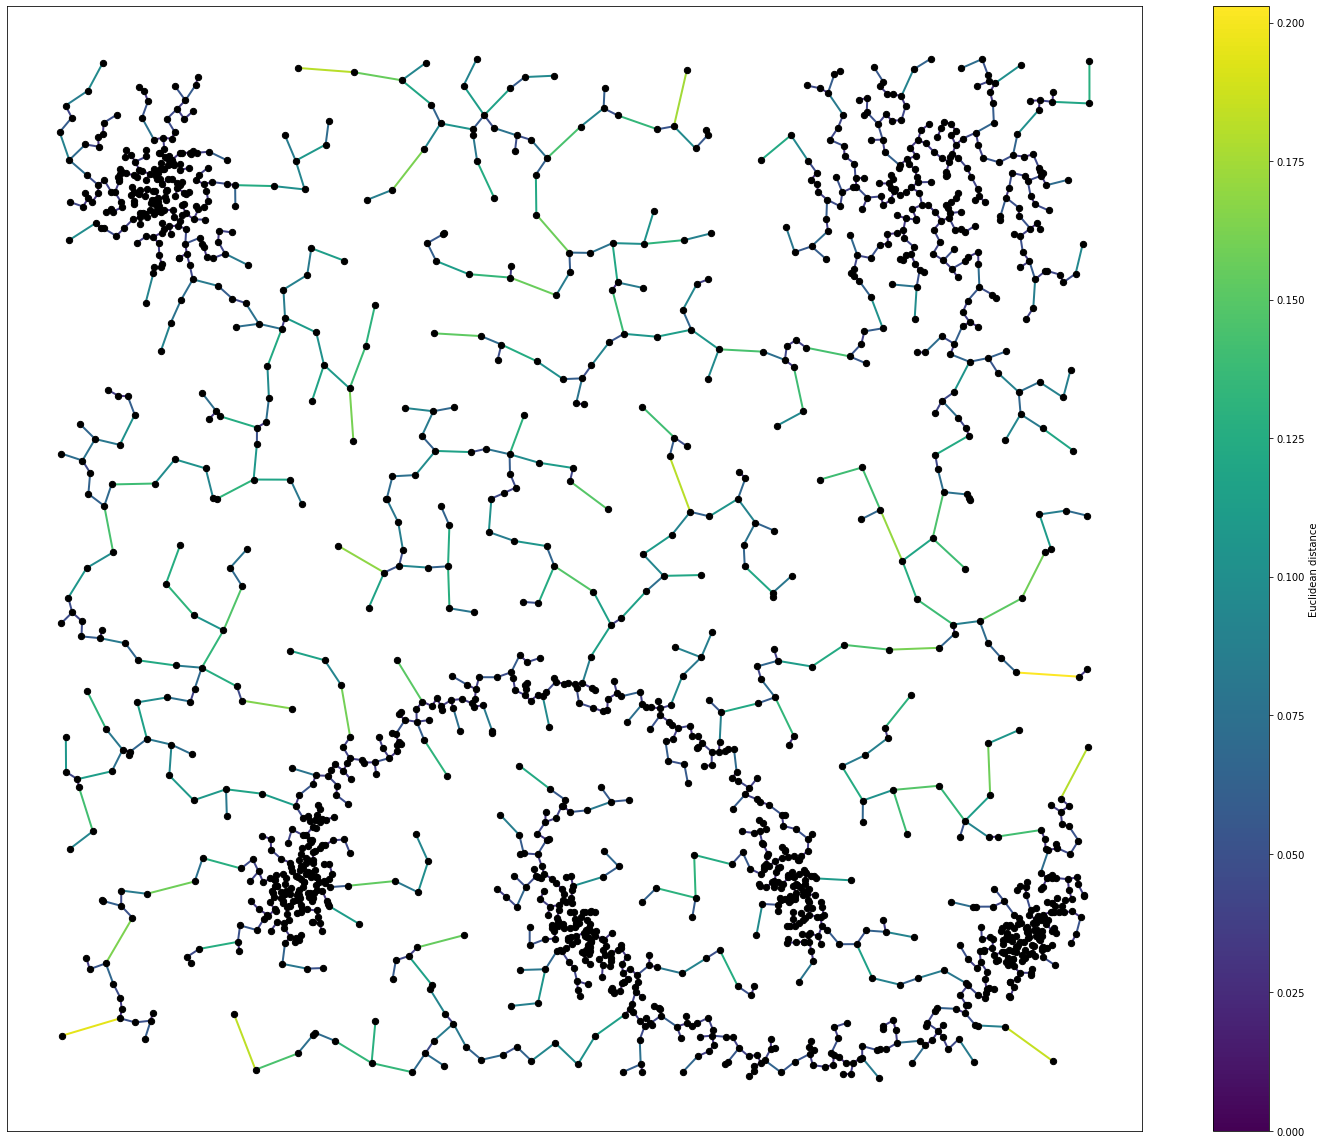

In [22]:
plt.figure(figsize=fig_size)
hqshift._emst.plot()
print(hqshift._emst.bandwidth)
plt.savefig('emst.png', bbox_inches='tight')
plt.show()

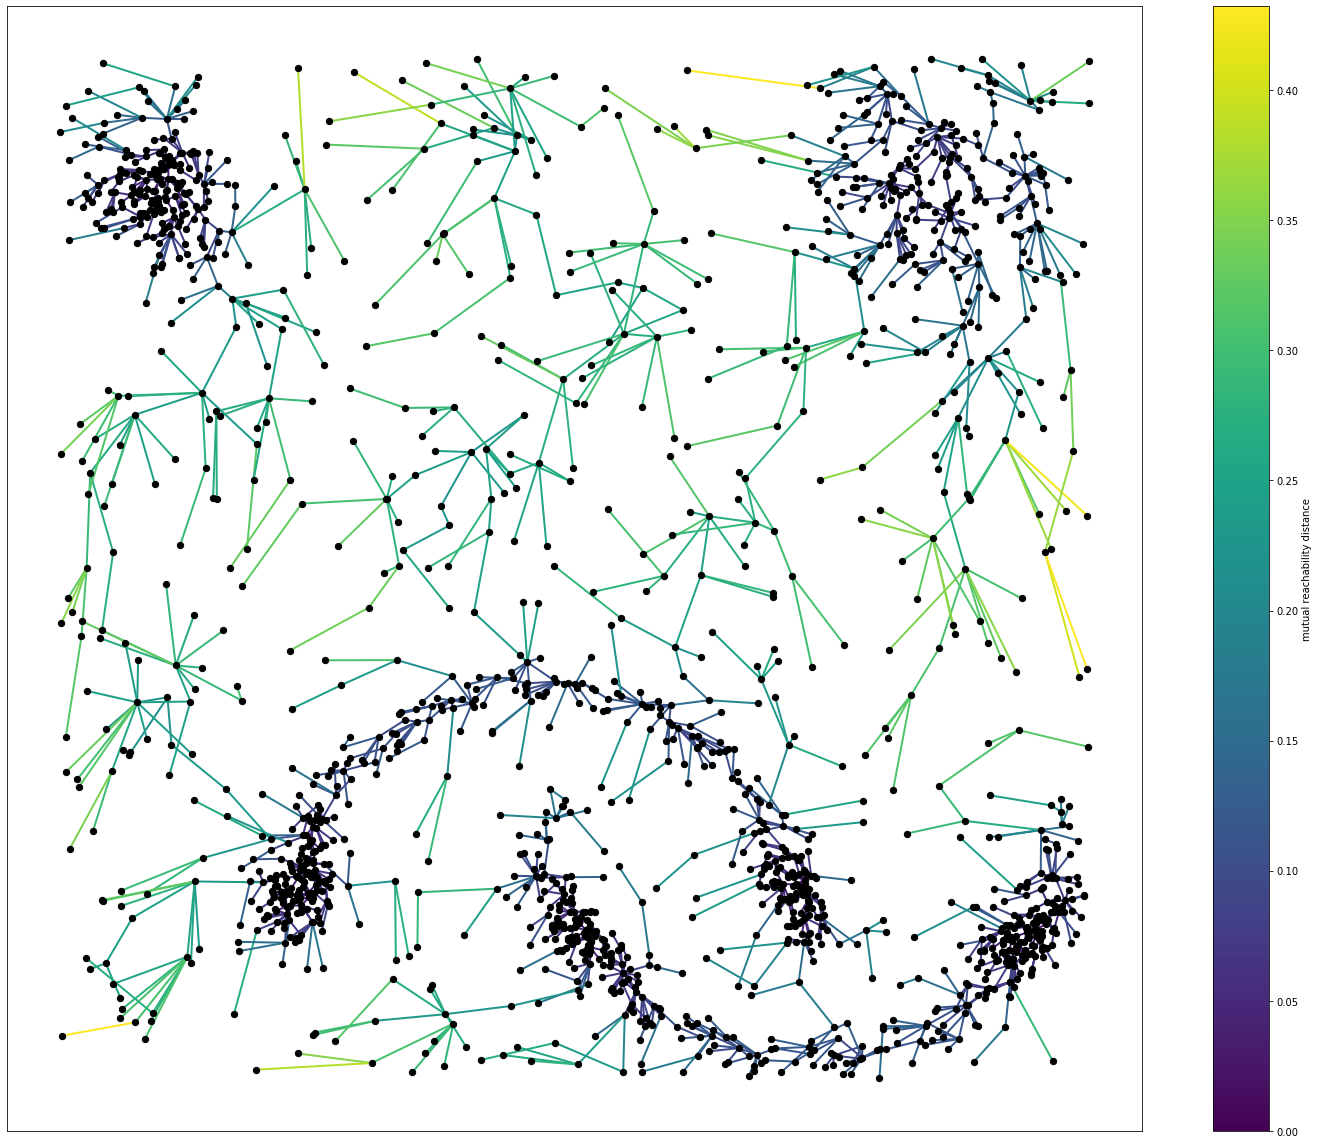

In [23]:
plt.figure(figsize=fig_size)
hqshift._mrmst.plot()
plt.savefig('mrmst.png', bbox_inches='tight')
plt.show()

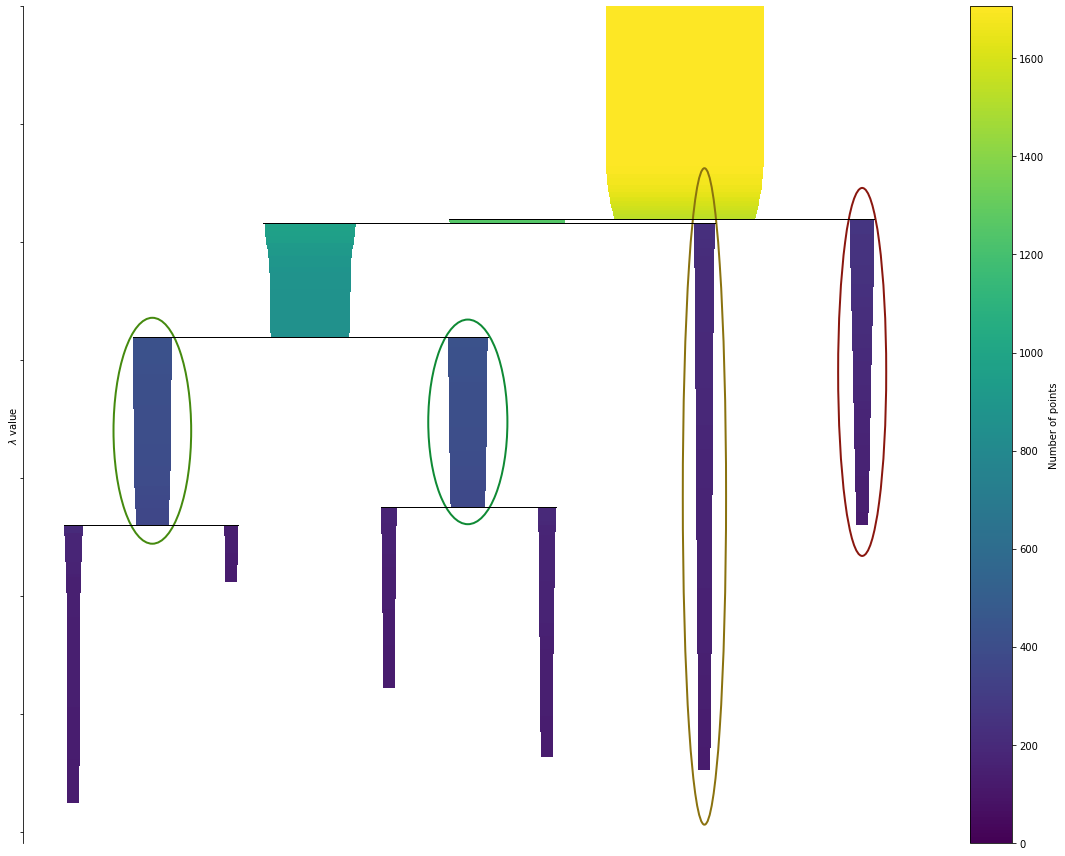

In [24]:
plt.figure(figsize=(16,12))
max_n_labels = np.maximum(8, np.unique(hqshift.labels_).max() + 1)
palette = sns.hls_palette(max_n_labels, l=.3, s=.8) 
hqshift.condensed_tree.plot(select_clusters=True,
                            selection_palette=palette,
                        log_size=False)
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.tight_layout()
plt.show() 

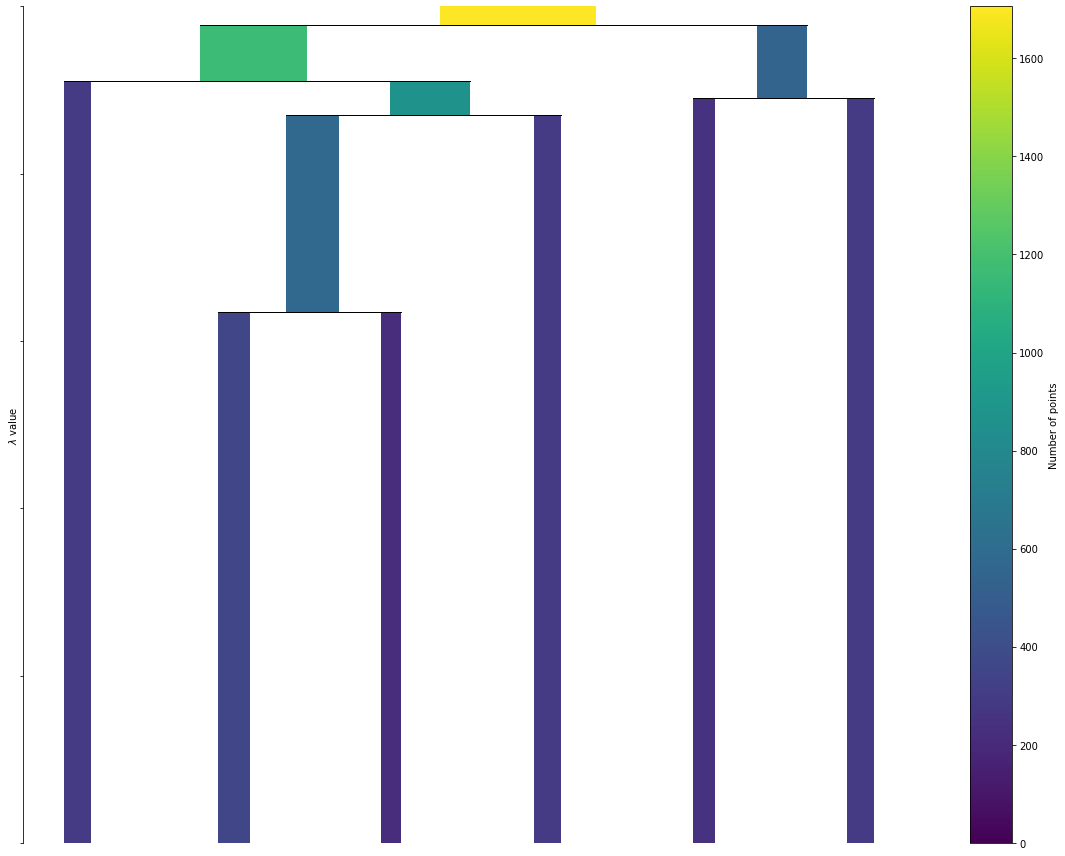

In [25]:
plt.figure(figsize=(16,12))
max_n_labels = np.maximum(8, np.unique(hqshift.labels_).max() + 1)
palette = sns.hls_palette(max_n_labels, l=.3, s=.8) 
hqshift.quick_shift_condensed_tree.plot(select_clusters=False,
                                        selection_palette=palette,
                                        log_size=False)
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.ylim(0.025)
plt.tight_layout()
plt.show() 

## Recurrent Neural Network (RNN) 
+ HQuickShift **restricts the steps to sample points (and thus is a sample-based version of Mean Shift)**.


+ What happens if we have **a new single point to cluster**? How to assign it to a mode? Re-run the HQuickShift?
  
  
+ Or find **the nn** in sample set and go forward? Then we need to **store all data samples**!


+ **Samples follow common paths towards to the local mode.**

In [14]:
len(hqshift.paths), hqshift._idx_root

(1706, [1178, 1479, 785, 968, 493, 1615])

### Train a RNN from Scratch

In [15]:
clust_paths = [[j]+pth[:pth.index(idx)+1] for idx in hqshift._idx_root 
                                          for j, pth in enumerate(hqshift.paths) if idx in pth]
clust_data = [test_data[pth] for pth in clust_paths] 
clust_paths 

[[13, 627, 1309, 755, 1293, 628, 1690, 1281, 477, 765, 1459, 1178],
 [23,
  142,
  1471,
  13,
  627,
  1309,
  755,
  1293,
  628,
  1690,
  1281,
  477,
  765,
  1459,
  1178],
 [24,
  633,
  946,
  1703,
  1015,
  453,
  568,
  858,
  340,
  649,
  945,
  1087,
  634,
  822,
  1319,
  884,
  730,
  259,
  1497,
  1700,
  134,
  765,
  1459,
  1178],
 [25, 323, 434, 691, 1329, 827, 1107, 147, 1163, 1178],
 [28,
  78,
  510,
  544,
  1253,
  1257,
  1415,
  1266,
  125,
  427,
  1381,
  509,
  1642,
  932,
  623,
  29,
  1036,
  551,
  970,
  198,
  1653,
  1131,
  306,
  1039,
  1325,
  1416,
  1459,
  1178],
 [29, 1036, 551, 970, 198, 1653, 1131, 306, 1039, 1325, 1416, 1459, 1178],
 [33,
  379,
  1447,
  1009,
  1699,
  264,
  1653,
  1131,
  306,
  1039,
  1325,
  1416,
  1459,
  1178],
 [38,
  395,
  267,
  174,
  1449,
  453,
  568,
  858,
  340,
  649,
  945,
  1087,
  634,
  822,
  1319,
  884,
  730,
  259,
  1497,
  1700,
  134,
  765,
  1459,
  1178],
 [51,
  1344,
  840,
  

In [16]:
# Construct Vocabulary, make sure BOS (<xxbos>) idx is 0
vocab_tok = [BOS] + [str(idx) for idx in np.arange(test_data.shape[0])]
# => ['<pad>', '0', '1', '2', '3',... 'seq_len-1']
vocab_ = {idx:tok for idx,tok in enumerate(vocab_tok)}
ids = [[0]+list(np.array(pth)+1) for pth in clust_paths]
ids[150], ids[-1], vocab_[ids[-1][-1]]

([0,
  869,
  1592,
  372,
  143,
  1472,
  14,
  628,
  1310,
  756,
  1294,
  629,
  1691,
  1282,
  478,
  766,
  1460,
  1179],
 [0,
  1704,
  1016,
  454,
  569,
  859,
  341,
  650,
  946,
  1088,
  635,
  823,
  1320,
  885,
  731,
  260,
  1498,
  1701,
  135,
  766,
  1460,
  1179,
  775,
  1069,
  761,
  1230,
  875,
  325,
  938,
  484,
  556,
  1401,
  1447,
  494,
  1344,
  857,
  1492,
  99,
  269,
  60,
  638,
  353,
  1499,
  598,
  1616],
 '1615')

In [17]:
vocab_tok[0], vocab_tok[-1], list(vocab_.items())[0], list(vocab_.items())[-1]

('xxbos', '1705', (0, 'xxbos'), (1706, '1705'))

In [18]:
nh=2
nt=128
bs=128
bptt=40
vocab=Vocab(vocab_)
pretrained_weights = np.vstack(([10.0, 10.0], test_data))
nv = len(vocab.itos); nv

1707

In [20]:
class Model_Density(nn.Module):
    def __init__(self, nv, nh, bs):
        super().__init__()
        self.nv = nv
        self.nh = nh
        self.nt = nt
        self.bs = bs
        self.i_h = nn.Embedding(self.nv,self.nh)
        # intialize the word vectors, pretrained_weights is a 
        # numpy array of size (vocab_size, hidden_size) and 
        # pretrained_weights[i] retrieves the word vector of
        # i-th word in the vocabulary
        self.i_h.weight.data.copy_(torch.from_numpy(pretrained_weights))
        self.i_h.weight.requires_grad = False
        self.h_t = nn.Linear(self.nh,self.nt)
        self.rnn = nn.GRU(self.nt, self.nt, 2, batch_first=True)
        self.h_o = nn.Linear(self.nt,self.nv)
        self.bn = BatchNorm1dFlat(self.nt)
        self.reset()    
    def reset(self):
        self.h = torch.zeros(2, self.bs, self.nt).cuda()  
    def forward(self, x):
        #import pdb;pdb.set_trace()
        res,h = self.rnn(self.h_t(self.i_h(x)), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))
    def forward_with_embedded(self, x):
        res,h = self.rnn(self.h_t(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [21]:
ids = np.array(ids)
data = TextLMDataBunch.from_ids('/tmp', vocab=vocab,
                                train_ids=ids, valid_ids=ids,
                                bs=bs, bptt=bptt, device=device)
data

TextLMDataBunch;

Train: LabelList (4931 items)
x: LMTextList
xxbos 13 627 1309 755 1293 628 1690 1281 477 765 1459 1178,xxbos 23 142 1471 13 627 1309 755 1293 628 1690 1281 477 765 1459 1178,xxbos 24 633 946 1703 1015 453 568 858 340 649 945 1087 634 822 1319 884 730 259 1497 1700 134 765 1459 1178,xxbos 25 323 434 691 1329 827 1107 147 1163 1178,xxbos 28 78 510 544 1253 1257 1415 1266 125 427 1381 509 1642 932 623 29 1036 551 970 198 1653 1131 306 1039 1325 1416 1459 1178
y: LMLabelList
,,,,
Path: /tmp;

Valid: LabelList (4931 items)
x: LMTextList
xxbos 13 627 1309 755 1293 628 1690 1281 477 765 1459 1178,xxbos 23 142 1471 13 627 1309 755 1293 628 1690 1281 477 765 1459 1178,xxbos 24 633 946 1703 1015 453 568 858 340 649 945 1087 634 822 1319 884 730 259 1497 1700 134 765 1459 1178,xxbos 25 323 434 691 1329 827 1107 147 1163 1178,xxbos 28 78 510 544 1253 1257 1415 1266 125 427 1381 509 1642 932 623 29 1036 551 970 198 1653 1131 306 1039 1325 1416 1459 1178
y: LMLabelList
,,,,
Path: /

In [22]:
data.valid_ds[0][0], data.bptt, len(data.valid_dl)

(<fastai.text.data.Text at 0x7f9331b57860>, 40, 33)

In [23]:
it = iter(data.valid_dl)
x1,y1 = next(it)
it.close()

In [24]:
x1[0]

tensor([   0,   14,  628, 1310,  756, 1294,  629, 1691, 1282,  478,  766, 1460,
        1179,    0,   24,  143, 1472,   14,  628, 1310,  756, 1294,  629, 1691,
        1282,  478,  766, 1460, 1179,    0,   25,  634,  947, 1704, 1016,  454,
         569,  859,  341,  650], device='cuda:0')

In [25]:
y1[0]

tensor([  14,  628, 1310,  756, 1294,  629, 1691, 1282,  478,  766, 1460, 1179,
           0,   24,  143, 1472,   14,  628, 1310,  756, 1294,  629, 1691, 1282,
         478,  766, 1460, 1179,    0,   25,  634,  947, 1704, 1016,  454,  569,
         859,  341,  650,  946], device='cuda:0')

In [26]:
v = data.valid_ds.vocab
v.textify(data.train_ds[0][0].data)

'xxbos 13 627 1309 755 1293 628 1690 1281 477 765 1459 1178'

In [27]:
random_seed(seed_value=seed, use_cuda=use_cuda)

In [28]:
learn = Learner(data, Model_Density(nv=nv, nh=nh, bs=bs), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


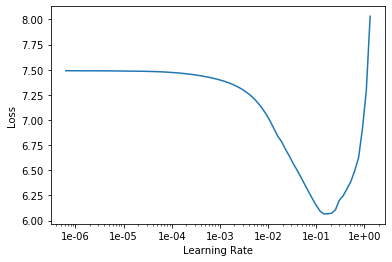

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(200, 1e-2);

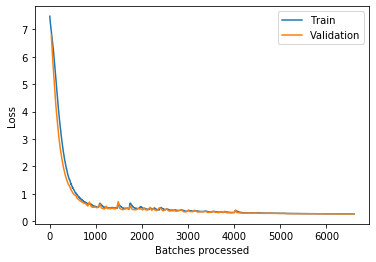

In [30]:
# epoch 	train_loss 	valid_loss 	accuracy
#1      	6.533147    	6.611041 	0.070201
#100    	0.397764    	0.400868 	0.915774
learn.recorder.plot_losses()

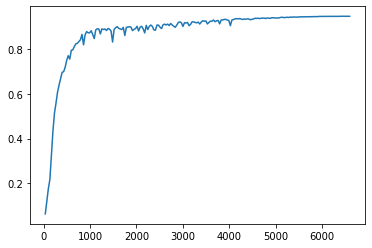

In [31]:
#epoch 	train_loss 	valid_loss 	accuracy
#200 	0.390284 	0.403612 	0.915976
learn.recorder.plot_metrics()

In [32]:
preds = learn.get_preds()
preds

[tensor([[[2.8479e-04, 1.8869e-04, 4.3575e-04,  ..., 8.4788e-04,
           2.6956e-04, 3.5801e-04],
          [1.7085e-17, 1.1150e-14, 1.8210e-11,  ..., 4.0638e-44,
           2.2000e-28, 8.1448e-26],
          [7.8851e-16, 2.7053e-11, 1.4436e-16,  ..., 1.2025e-37,
           6.8574e-24, 1.1375e-25],
          ...,
          [1.8901e-12, 3.6819e-16, 4.7385e-19,  ..., 3.4443e-20,
           1.6986e-16, 2.8513e-11],
          [9.4661e-09, 8.5445e-14, 1.1175e-16,  ..., 6.2395e-15,
           9.2918e-11, 1.5421e-10],
          [4.7298e-11, 4.8956e-14, 6.2887e-12,  ..., 4.3914e-18,
           1.7530e-16, 6.7330e-12]],
 
         [[3.6172e-04, 3.3068e-17, 8.0418e-15,  ..., 3.2444e-24,
           2.7267e-15, 5.0313e-16],
          [2.1805e-02, 6.3079e-14, 2.4923e-11,  ..., 8.6841e-13,
           8.2163e-15, 2.8146e-11],
          [3.7471e-02, 5.0946e-14, 3.8290e-08,  ..., 1.5797e-22,
           8.0887e-15, 2.6675e-18],
          ...,
          [4.9356e-17, 1.3540e-15, 2.3281e-14,  ..., 2.300

### Load a RNN model already trained

Call the function from the jupyter notebook current folder:
+ learn.load(datapath4file(URLs.LOCAL_PATH/'models'/'name.gru.model.you.want.to.load'))

**You need to run the ``class Model_Density(nn.Module)`` cells ABOVE first!**

In [30]:
m = learn.model
#set batch size to 1
learn.model.bs=1
#turn off dropout
m.eval()
#reset hidden state
m.reset() 
idxs = learn.data.train_ds[150][0].data
idxs = idxs[None,:]
print(idxs, idxs.shape)
p = m.forward(torch.tensor(idxs, device=device))
cls = F.softmax(p[0], dim=1).argmax(dim=1)
cls

[[   0  869 1592  372  143 1472   14  628 1310  756 1294  629 1691 1282  478  766 1460 1179]] (1, 18)


tensor([ 210, 1592,  372,  143, 1472,   14,  628, 1310,  756, 1294,  629, 1691,
        1282,  478,  766, 1460, 1179,  775], device='cuda:0')

In [31]:
m = learn.model
#set batch size to 1
learn.model.bs=1
#turn off dropout
m.eval()
#reset hidden state
m.reset() 

idxs = np.array([0, 869, 1592, 372, 143, 1472])
idxs = idxs[None,:]
p = m.forward(torch.tensor(idxs, device=device))
cls = F.softmax(p[0], dim=1).argmax(dim=1)
cls

tensor([ 210, 1592,  372,  143, 1472,   14], device='cuda:0')

In [32]:
m.i_h(torch.tensor(idxs, device=device))

tensor([[[10.0000, 10.0000],
         [ 1.2430,  1.6694],
         [ 1.2245,  1.6757],
         [ 1.2272,  1.6428],
         [ 1.2363,  1.6086],
         [ 1.2392,  1.5499]]], device='cuda:0')

In [33]:
m = learn.model
#set batch size to 1
learn.model.bs=1
#turn off dropout
m.eval()
#reset hidden state
m.reset() 

p = m.forward_with_embedded(torch.tensor([[[10.0000, 10.0000],
         [ 1.2430,  1.6694],
         [ 1.2245,  1.6757],
         [ 1.2272,  1.6428],
         [ 1.2363,  1.6086],
         [ 1.2392,  1.5499]]], device=device))
cls = F.softmax(p[0], dim=1).argmax(dim=1)
cls

tensor([ 210, 1592,  372,  143, 1472,   14], device='cuda:0')

In [34]:
sorted([ridx+1 for ridx in hqshift._idx_root])

[494, 786, 969, 1179, 1480, 1616]

And test the RNN output with some rounded inputs:

9.184154033660889


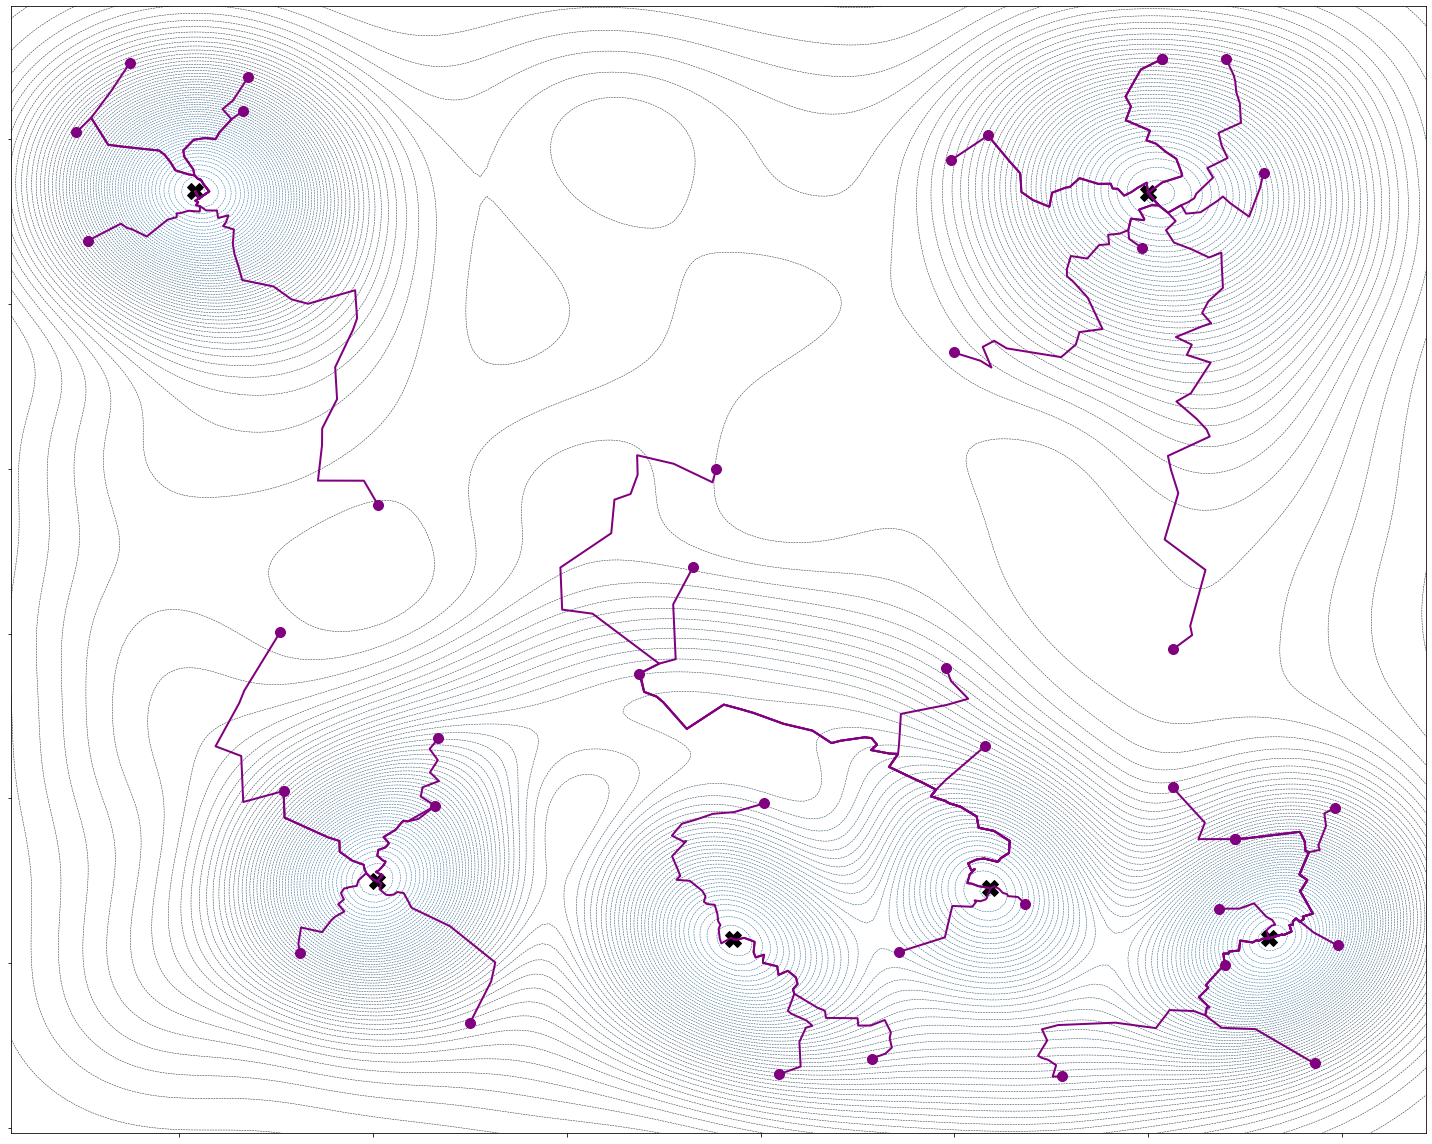

In [36]:
from sklearn.neighbors import NearestNeighbors

import time
fig, ax = plt.subplots(figsize=fig_size)
t0 = time.time()
sns.kdeplot(test_data[:,0],test_data[:,1],
            gridsize=256, n_levels=64, bw=hqshift._emst.bandwidth, 
            ax=ax, shade_lowest=False, linestyles='--', linewidths=0.5)
print(time.time()-t0)

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(test_data)
query_points = [[-0.200, 0.2000], [-0.300, -0.100], [1.0000, 1.2000], [1.3000, 1.4000],
                [1.0000, 1.8000], [-2.000, 1.0000], [-1.200, 1.8000], [-1.200, -1.000],
                [1.2000, -1.000], [1.2000, -0.800], [1.0000, -0.500], [-1.200, -0.500],
                [-2.000, 1.4000], [-1.000, 0.4000], [-2.000, 2.0000], [-0.800, -1.100],
                [1.6000, -0.500], [1.5500, -1.000], [-0.800, -0.300], [-1.250, 0.0000],
                [0.0000, -1.300], [0.3000, -1.300], [0.0000, -0.500], [0.7000, -0.800],
                [0.6000, -0.400], [0.6000, 1.5000], [-1.300, 1.6000], [1.0000, 1.7500],
                [0.3500, -1.000], [-0.800, -0.500], [1.2000, 1.9000], [1.2000, -0.700],
                [0.5000, -0.100], [0.0000, 0.5000], [1.2000, -0.700], [0.5000, 1.0000],
                [0.8000, -1.400], [1.5000, -1.400], [0.5000, 1.5000], [1.0000, 0.0000]]

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.tight_layout()

distances, indices = nbrs.kneighbors(query_points)
#_idx_root := [494, 786, 969, 1179, 1480, 1616]
for idx in hqshift._idx_root:
    plt.plot((test_data[idx][0]),
             (test_data[idx][1]), 'X', color='k', markersize=16)

for q_p in indices:   
    m = learn.model
    #set batch size to 1
    learn.model.bs=1
    #turn off dropout
    m.eval()
    #reset hidden state
    m.reset()

    idxs = np.array([0, q_p[0]+1])
    idxs = torch.tensor(idxs, device=device)
    for _ in np.arange(bptt):
        p = m.forward(idxs[None,:])
        cls = F.softmax(p[0], dim=1).argmax(dim=1)
        if cls[-1].item()==0: print(0); break
        idxs = torch.cat((idxs, cls[-1].unsqueeze(0)))
        if cls[-1].item() in ([ridx+1 for ridx in hqshift._idx_root]): break
#     print(idxs)    
#     import pdb;pdb.set_trace()
    plt.plot(*test_data[idxs[1:]-1][0], 'o', color='purple', markersize=10)
    plt.plot(*test_data[idxs[1:]-1].T, color='purple', linewidth=2)
    
curaxes = plt.gca()
curaxes.set_xlim(ax_xlim)
curaxes.set_ylim(ax_ylim) 
fig.savefig('rnn_out.png', dpi=200, bbox_inches='tight')

# Sklearn Benchmarks

**Synthetic Dataset Comparison:** HQuickShift settings are min cluster size = 30, min mode size = 50, min sample = 1 and the bandwidth is estimated with EMST of HQuickShift. Quickshift++ settings are fixed at k = 20, β = 0.7 as suggested by authors. For DBSCAN we use the settings given in sklearn clustering benchmark.The bandwidth for QuickShift is estimated with estimate bandwidth routine (parameter quantile = .005) of sklearn.cluster module and tuned further to obtain a reasonable number of clusters for all datasets.

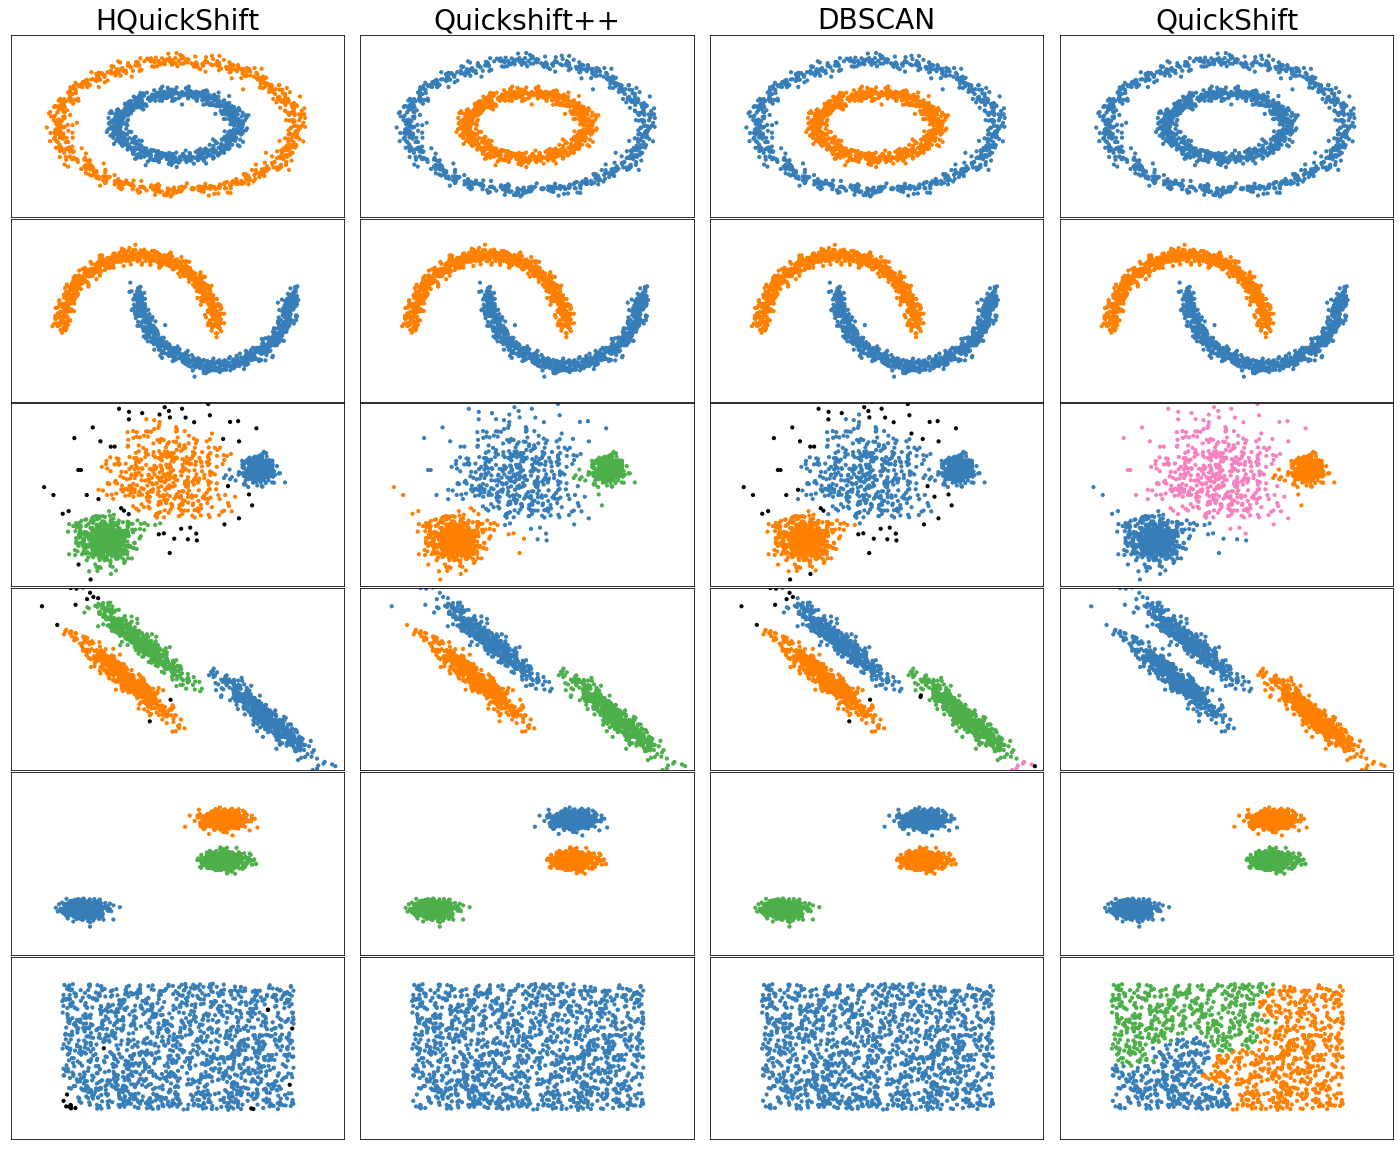

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from QuickshiftPP import *
import hdbscan

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=fig_size)
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .005,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    hqshift = HQSHIFT(min_cluster_size=30, min_mode_size=50, min_samples=1, allow_single_cluster=True)
    quickshiftpp = QuickshiftPP(k=20, beta=.7)
    dbscan = cluster.DBSCAN(eps=params['eps'])
    quick_s_norm = QuickShift(window_type="normal", bandwidth=bandwidth*0.85)

    clustering_algorithms = (
        ('HQuickShift', hqshift),
        ('Quickshift++', quickshiftpp),
        ('DBSCAN', dbscan),
        ('QuickShift', quick_s_norm),)

    for name, algorithm in clustering_algorithms:

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        elif hasattr(algorithm, 'memberships'):
            y_pred = algorithm.memberships
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=28)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.savefig('benchmark_sklearn.png', dpi=200, bbox_inches='tight')
plt.show()

# Real Dataset Benchmarks

In [30]:
#%reload_ext memory_profiler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import math
import umap
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
seed = 0
seed_lst = [0, 23, 42, 1234, 43210, 1133557799, 22446688, 123456789, 987654321, 86420]
random_seed(seed_value=seed, use_cuda=use_cuda)

## Collect and Plot Batch Run Results

The ``*.pkl`` files contained results of the experiments are produced with ``parameter_select.py`` script located under ``data_sets\XX_bunch`` folders. First run those scripts to produce the results and then you can collect and plot the results here:

seeds qshiftpp 19
seeds qshiftpp 0.6
iris qshiftpp 18
iris qshiftpp 0.1
banknote qshiftpp 66
banknote qshiftpp 0.6
mnist hdbscan 6
mnist hdbscan 15
seeds hdbscan 43
seeds hdbscan 15
mnist qshiftpp 77
mnist qshiftpp 0.30000000000000004
banknote hdbscan 2
banknote hdbscan 114
glass qshiftpp 28
glass qshiftpp 0.4
iris hdbscan 4
iris hdbscan 15
glass hdbscan 2
glass hdbscan 11
page-blocks hdbscan 19
page-blocks hdbscan 15
page-blocks qshiftpp 260
page-blocks qshiftpp 0.6
phoneme hdbscan 71
phoneme hdbscan 15
phoneme qshiftpp 46
phoneme qshiftpp 0.8


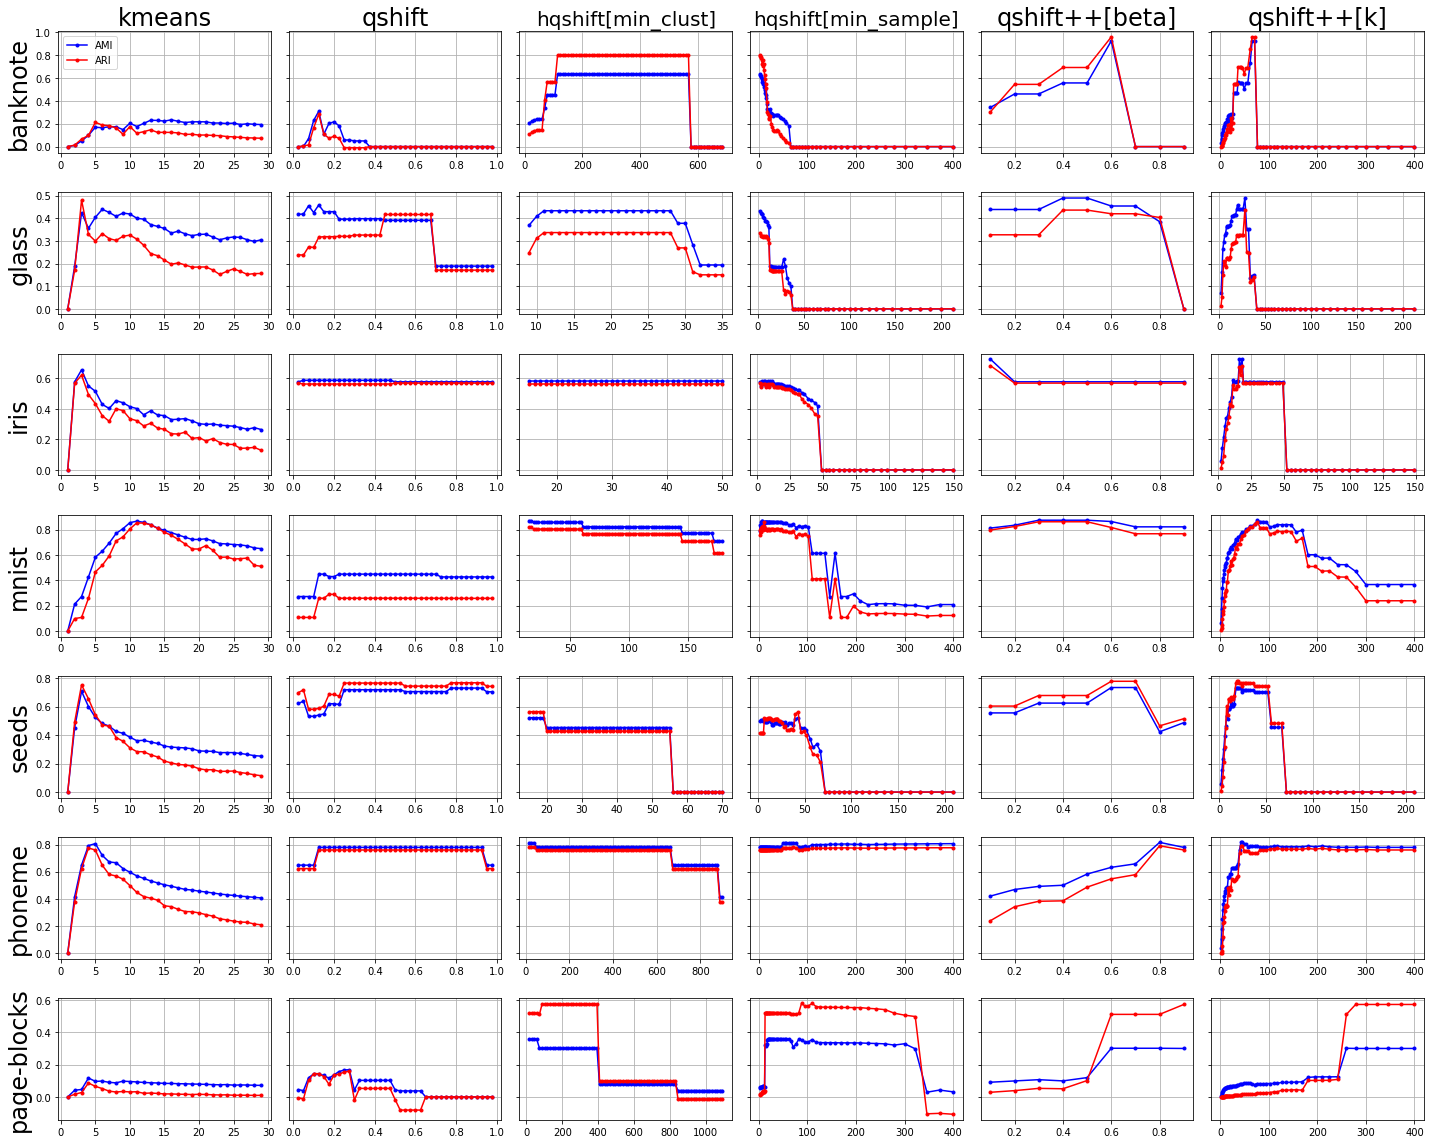

In [28]:
import pickle

datasets = ['banknote', 'glass', 'iris', 'mnist', 'seeds', 'phoneme', 'page-blocks']
methods  = ['kmeans', 'qshift', 'hdbscan', 'qshiftpp']
rowidx   = {ds:i for i,ds in enumerate(datasets)}
colidx   = {mt:i for i,mt in enumerate(methods)}

fig1, axes1 = plt.subplots(nrows=len(datasets), ncols=len(methods)+2, sharey="row", figsize=fig_size)
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
for filename in glob.iglob('data_sets/**/*.pkl', recursive=True):
#     print(filename)
    fname = os.path.splitext(os.path.basename(filename))[0]
#     print(fname)
    fname_parts = fname.split('_')
    dataset = fname_parts[0]
    method = fname_parts[1]
    ri, ci = rowidx[dataset], colidx[method]
    if len(fname_parts) == 2:
        if ri == 0:
            axes1[ri, ci].set_title(method, size=24)
        if ci == 0:
            axes1[ri, ci].set_ylabel(dataset, size=24)
        with open(filename, 'rb') as input_file:
            datadict = pickle.load(input_file)
            if method == 'kmeans': 
                axes1[ri, ci].plot(datadict['k'], datadict['ami'], 'b.-', label='AMI')
                axes1[ri, ci].plot(datadict['k'], datadict['ari'], 'r.-', label='ARI')
                axes1[ri, ci].grid()
                if ri == 0 and ci == 0: axes1[ri, ci].legend(loc='upper left')
           
            elif method == 'qshift':
                axes1[ri, ci].plot(datadict['bw'], datadict['ami'], 'b.-',
                                   datadict['bw'], datadict['ari'], 'r.-')
                axes1[ri, ci].grid()
                
            elif method == 'hdbscan':
                if ri == 0: axes1[ri, ci].set_title('hqshift[min_clust]', size=20)
                best_idx_ari = np.argmax(datadict['ari'])
                best_idx_nmi = np.argmax(datadict['ami'])
                best_min_sample_size = datadict['k'][best_idx_nmi]
                best_k_idx = np.where(np.array(datadict['k'])==best_min_sample_size)[0]
                axes1[ri, ci].plot(np.array(datadict['minclst'])[best_k_idx],
                                   np.array(datadict['ami'])[best_k_idx], 'b.-',
                                   np.array(datadict['minclst'])[best_k_idx],
                                   np.array(datadict['ari'])[best_k_idx], 'r.-')
                axes1[ri, ci].grid()
                print(dataset, method, best_min_sample_size)
                
                if ri == 0: axes1[ri, ci+1].set_title('hqshift[min_sample]', size=20)                
                best_minclst = datadict['minclst'][best_idx_nmi]
                best_minclst_idx = np.where(np.array(datadict['minclst'])==best_minclst)[0]
                axes1[ri, ci+1].plot(np.array(datadict['k'])[best_minclst_idx],
                                   np.array(datadict['ami'])[best_minclst_idx], 'b.-',
                                   np.array(datadict['k'])[best_minclst_idx],
                                   np.array(datadict['ari'])[best_minclst_idx], 'r.-')
                axes1[ri, ci+1].grid()
                print(dataset, method, best_minclst)
            else:
                if ri == 0: axes1[ri, ci+1].set_title('qshift++[beta]', size=24) 
                best_idx_ari = np.argmax(datadict['ari'])
                best_idx_nmi = np.argmax(datadict['ami'])
                best_k_idx = np.where(np.array(datadict['k'])==datadict['k'][best_idx_nmi])[0]
                axes1[ri, ci+1].plot(np.array(datadict['b'])[best_k_idx],
                                   np.array(datadict['ami'])[best_k_idx], 'b.-',
                                   np.array(datadict['b'])[best_k_idx],
                                   np.array(datadict['ari'])[best_k_idx], 'r.-')
                axes1[ri, ci+1].grid()
                print(dataset, method, datadict['k'][best_idx_nmi])
                
                if ri == 0: axes1[ri, ci+2].set_title('qshift++[k]', size=24) 
                best_idx_ari = np.argmax(datadict['ari'])
                best_idx_nmi = np.argmax(datadict['ami'])
                best_b_idx = np.where(np.array(datadict['b'])==datadict['b'][best_idx_nmi])[0]
                axes1[ri, ci+2].plot(np.array(datadict['k'])[best_b_idx],
                                   np.array(datadict['ami'])[best_b_idx], 'b.-',
                                   np.array(datadict['k'])[best_b_idx],
                                   np.array(datadict['ari'])[best_b_idx], 'r.-')
                axes1[ri, ci+2].grid()
                print(dataset, method, datadict['b'][best_idx_nmi])
        plt.tight_layout()
        plt.savefig('experiment_1.png', dpi=200, bbox_inches='tight')

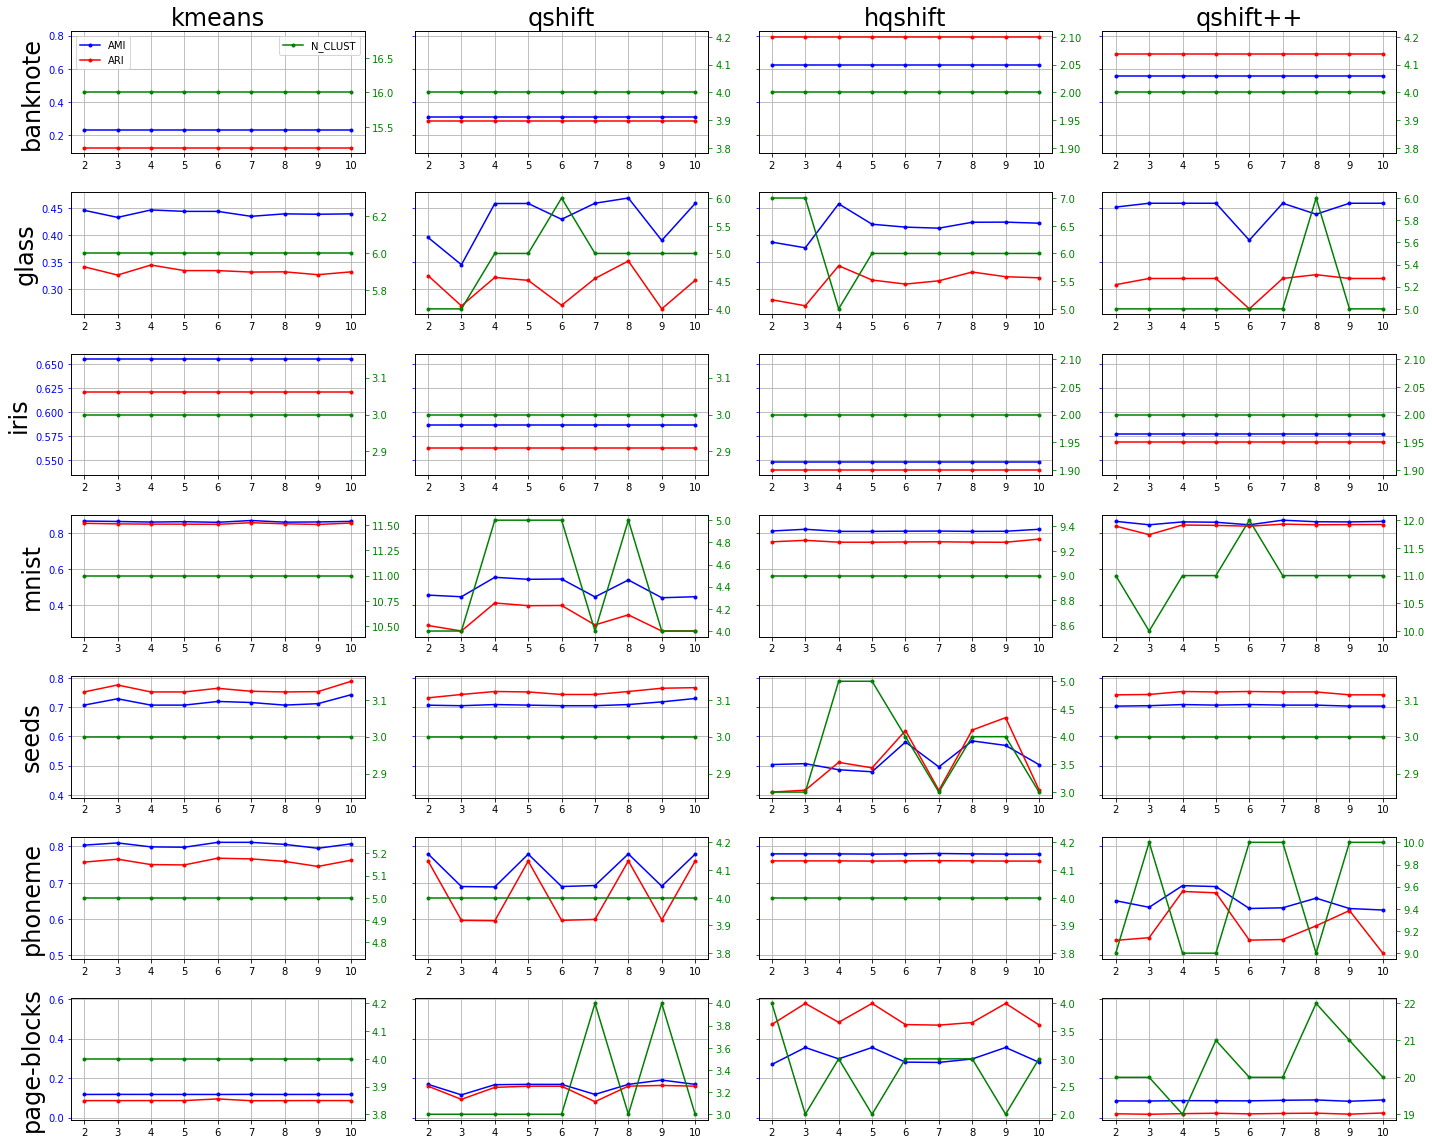

In [64]:
fig2, axes2 = plt.subplots(nrows=len(datasets), ncols=len(methods), sharey="row", figsize=fig_size)
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
for filename in glob.iglob('data_sets/**/*.pkl', recursive=True):
#     print(filename)
    fname = os.path.splitext(os.path.basename(filename))[0]
#     print(fname)
    fname_parts = fname.split('_')
    dataset = fname_parts[0]
    method = fname_parts[1]
    ri, ci = rowidx[dataset], colidx[method]
    if len(fname_parts) > 2:
        if ci == 0:
            axes2[ri, ci].set_ylabel(dataset, size=24)
        with open(filename, 'rb') as input_file:
            datadict = pickle.load(input_file)
            t = np.arange(1, 11)[1:]
            axes2[ri, ci].plot(t, datadict['ami'][1:], 'b.-', label='AMI') 
            axes2[ri, ci].plot(t, datadict['ari'][1:], 'r.-', label='ARI')
            axes2[ri, ci].tick_params('y', colors='b')
            #axes2[ri, ci].set_xlabel('Run [index]')
            ax2 = axes2[ri, ci].twinx()
            ax2.plot(t, datadict['n_clusters'][1:], 'g.-', label='N_CLUST')
            ax2.tick_params('y', colors='g')
            #ax2.set_ylabel('number of clusters', color='g')  
            if method == 'kmeans':
                if ri == 0: axes2[ri, ci].set_title(method, size=24)
                if ri == 0 and ci == 0:
                    axes2[ri, ci].legend(loc='upper left')
                    ax2.legend(loc='upper right')
            elif method == 'qshift':
                if ri == 0: axes2[ri, ci].set_title('qshift', size=24)
            elif method == 'hdbscan':
                if ri == 0: axes2[ri, ci].set_title('hqshift', size=24)     
            else:
                if ri == 0: axes2[ri, ci].set_title('qshift++', size=24) 
        
        axes2[ri, ci].grid()
        plt.tight_layout()
        plt.savefig('experiment_2.png', dpi=200, bbox_inches='tight')

## Quick Test

In this section, we perform some tests with real datasets to demonstrate their performance:

In [60]:
#data0 = pd.read_csv("data_sets/00_bunch/banknote/banknote.csv", header=None)
#data0 = pd.read_csv("data_sets/00_bunch/glass/glass.csv", header=None)
#data0 = pd.read_csv("data_sets/00_bunch/iris/iris.csv", header=None)
#data0 = pd.read_csv("data_sets/00_bunch/mnist/mnist.csv", header=None)
#data0 = pd.read_csv("data_sets/00_bunch/seeds/seeds.csv", header=None)
data0 = pd.read_csv("data_sets/01_bunch/phoneme/phoneme.csv", header=None)
#data0 = pd.read_csv("data_sets/02_bunch/page-blocks/page-blocks.csv", header=None)

X = data0.iloc[:,:-1].values
y = data0.iloc[:, -1].values

In [61]:
X.shape, y.shape

((4508, 256), (4508,))

In [62]:
num_classes = np.unique(y).shape[0]
num_samples = y.shape[0]
# find minority class label
num_samples_minority = math.inf
for lbl in np.unique(y):
    curr_num_samples = y[y==lbl].shape[0]
    if curr_num_samples < num_samples_minority:
        num_samples_minority = curr_num_samples
        min_label = lbl
print(min_label, num_classes, num_samples_minority, num_samples)

2 5 695 4508


In [63]:
if X.shape[1] > 4: 
    X = umap.UMAP(
        n_neighbors=50,
        min_dist=0.0,
        n_components=4,
        random_state=seed,
    ).fit_transform(X)

In [279]:
X.shape, y.shape

((1372, 4), (1372,))

### HDBSCAN

In [280]:
best_min_cluster_size = 17
if X.shape[0] > 1000:
    best_min_cluster_size = 125
best_min_sample_size = 3
best_min_mode_size = best_min_cluster_size

In [281]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_sample_size)
y_hat = clusterer.fit_predict(X)
print("Adj. Rand Index Score: %f." % adjusted_rand_score(y_hat, y))
print("Adj. Mutual Info Score: %f." % adjusted_mutual_info_score(y_hat, y))
print('Classes: ', np.unique(y_hat), 'n_clusters: ', np.unique(y_hat)[-1]+1)

Adj. Rand Index Score: 0.792122.
Adj. Mutual Info Score: 0.625601.
Classes:  [-1  0  1] n_clusters:  2


In [282]:
clustered = (y_hat >= 0)
(
    adjusted_rand_score(y[clustered], y_hat[clustered]),
    adjusted_mutual_info_score(y[clustered], y_hat[clustered])
)

(0.9649402548773788, 0.9342344910570453)

In [283]:
y_hat[y_hat==-1].shape

(127,)

### Quickshift++

In [284]:
X_qspp = X.copy(order='C')
k=25
if X.shape[0] > 1000:
    k = 60
model = QuickshiftPP(k=k, beta=.6)
# Compute the clustering.
model.fit(X_qspp)
y_hat = model.memberships
print("Adj. Rand Index Score: %f." % adjusted_rand_score(y_hat, y))
print("Adj. Mutual Info Score: %f." % adjusted_mutual_info_score(y_hat, y))
print('Classes: ', np.unique(y_hat), 'n_clusters: ', np.unique(y_hat)[-1]+1)

Adj. Rand Index Score: 0.690146.
Adj. Mutual Info Score: 0.555389.
Classes:  [0 1 2 3] n_clusters:  4


### HQSHIFT

In [285]:
hqshift = HQSHIFT(min_cluster_size=best_min_cluster_size,
                  min_mode_size=best_min_mode_size,
                  min_samples=best_min_sample_size,
                  allow_single_cluster=False).fit(X)
# cluster labels
y_hat = hqshift.labels_
print("Adj. Rand Index Score: %f." % adjusted_rand_score(y_hat, y))
print("Adj. Mutual Info Score: %f." % adjusted_mutual_info_score(y_hat, y))
print('Classes: ', np.unique(y_hat), 'n_clusters: ', np.unique(y_hat)[-1]+1)

Adj. Rand Index Score: 0.798521.
Adj. Mutual Info Score: 0.632384.
Classes:  [-1  0  1] n_clusters:  2


In [286]:
clustered = (y_hat >= 0)
(
    adjusted_rand_score(y[clustered], y_hat[clustered]),
    adjusted_mutual_info_score(y[clustered], y_hat[clustered])
)

(0.9650794905641422, 0.9344698677014239)

In [287]:
y_hat[y_hat==-1].shape

(122,)

In [288]:
len(hqshift.paths), hqshift._idx_root

(1372, [1334, 1002, 35, 180, 63, 1062])

In [289]:
clust_paths = [[j]+pth[:pth.index(idx)+1] for idx in hqshift._idx_root 
                                          for j, pth in enumerate(hqshift.paths) if idx in pth]
clust_data = [X[pth] for pth in clust_paths] 
# Construct Vocabulary, make sure BOS (<xxbos>) idx is 0
vocab_tok = [BOS] + [str(idx) for idx in np.arange(X.shape[0])]
# => ['<pad>', '0', '1', '2', '3',... 'seq_len-1']
vocab_ = {idx:tok for idx,tok in enumerate(vocab_tok)}
ids = [[0]+list(np.array(pth)+1) for pth in clust_paths]
#ids[150], ids[-1], vocab_[ids[-1][-1]]
len(clust_paths)

3058

In [290]:
nh=256
bs=128
bptt=20
vocab=Vocab(vocab_)
nv = len(vocab.itos); nv

1373

In [291]:
class Model_Density(nn.Module):
    def __init__(self, nv, nh, bs):
        super().__init__()
        self.nv = nv
        self.nh = nh
        self.bs = bs
        self.i_h = nn.Embedding(self.nv,self.nh)
        self.rnn = nn.GRU(self.nh, self.nh, 2, batch_first=True)
        self.h_o = nn.Linear(self.nh, self.nv)
        self.bn = BatchNorm1dFlat(self.nh)
        self.reset()
    def reset(self):
        self.h = torch.zeros(2, self.bs, self.nh).cuda()  
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [292]:
ids = np.array(ids)
data = TextLMDataBunch.from_ids('/tmp', vocab=vocab,
                                train_ids=ids, valid_ids=ids,
                                bs=bs, bptt=bptt, device=device)
data

TextLMDataBunch;

Train: LabelList (3058 items)
x: LMTextList
xxbos 30 936 1058 1119 814 1029 1266 997 1334,xxbos 95 326 908 1030 1091 1152 847 786 969 915 834 1002 903 916 1215 849 922 1205 1266 997 1334,xxbos 326 908 1030 1091 1152 847 786 969 915 834 1002 903 916 1215 849 922 1205 1266 997 1334,xxbos 349 807 1226 1287 1165 860 799 1348 1104 921 1043 1113 930 846 968 785 1334,xxbos 764 825 1037 1139 773 1198 1137 1259 915 834 1002 903 916 1215 849 922 1205 1266 997 1334
y: LMLabelList
,,,,
Path: /tmp;

Valid: LabelList (3058 items)
x: LMTextList
xxbos 30 936 1058 1119 814 1029 1266 997 1334,xxbos 95 326 908 1030 1091 1152 847 786 969 915 834 1002 903 916 1215 849 922 1205 1266 997 1334,xxbos 326 908 1030 1091 1152 847 786 969 915 834 1002 903 916 1215 849 922 1205 1266 997 1334,xxbos 349 807 1226 1287 1165 860 799 1348 1104 921 1043 1113 930 846 968 785 1334,xxbos 764 825 1037 1139 773 1198 1137 1259 915 834 1002 903 916 1215 849 922 1205 1266 997 1334
y: LMLabelList
,,,,
Path: /tmp;

In [293]:
random_seed(seed_value=seed, use_cuda=use_cuda)
learn = Learner(data, Model_Density(nv, nh, bs), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


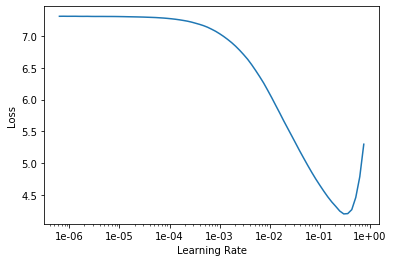

In [294]:
learn.lr_find()
learn.recorder.plot()

In [295]:
learn.fit_one_cycle(50, 1e-2);

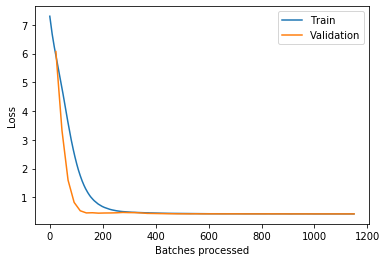

In [296]:
learn.recorder.plot_losses()

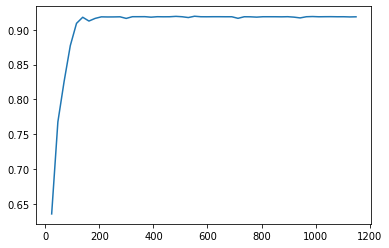

In [297]:
learn.recorder.plot_metrics()

In [298]:
# paths, number of samples
len(learn.data.train_ds), X.shape[0]

(3058, 1372)

In [299]:
stop_cond = sorted([ridx+1 for ridx in hqshift._idx_root])
stop_cond

[36, 64, 181, 1003, 1063, 1335]

In [300]:
y_hat = -2*np.ones(X.shape[0])

for q_p in range(X.shape[0]):
    m = learn.model
    #set batch size to 1
    learn.model.bs=1
    #turn off dropout
    m.eval()
    #reset hidden state
    m.reset()
    idxs = np.array([0, q_p+1])
    idxs = torch.tensor(idxs, device=device)
    
#     import pdb; pdb.set_trace()
    for _ in range(bptt):
        p = m.forward(idxs[None,:])
        cls = F.softmax(p[0], dim=1).argmax(dim=1)
        if cls[-1].item()==0: print(0); break
        idxs = torch.cat((idxs, cls[-1].unsqueeze(0)))
        if cls[-1].item() in stop_cond: break
        #import pdb;pdb.set_trace()
    #set the class label from the last index of the trajectory produced by HQuickShift
    y_hat[q_p] = hqshift.labels_[idxs[-1]-1] 
    print(q_p, y_hat[q_p])
#     import pdb; pdb.set_trace()

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 1.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 1.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 1.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

1041 1.0
1042 1.0
1043 1.0
1044 1.0
1045 1.0
1046 1.0
1047 1.0
1048 1.0
1049 1.0
1050 1.0
1051 1.0
1052 1.0
1053 1.0
1054 1.0
1055 1.0
1056 1.0
1057 1.0
1058 1.0
1059 1.0
1060 1.0
1061 1.0
1062 0.0
1063 1.0
1064 1.0
1065 1.0
1066 1.0
1067 1.0
1068 1.0
1069 1.0
1070 1.0
1071 1.0
1072 1.0
1073 1.0
1074 1.0
1075 1.0
1076 1.0
1077 1.0
1078 1.0
1079 1.0
1080 1.0
1081 1.0
1082 1.0
1083 1.0
1084 1.0
1085 1.0
1086 1.0
1087 1.0
1088 1.0
1089 1.0
1090 1.0
1091 1.0
1092 1.0
1093 1.0
1094 1.0
1095 1.0
1096 1.0
1097 1.0
1098 1.0
1099 1.0
1100 1.0
1101 1.0
1102 1.0
1103 1.0
1104 1.0
1105 1.0
1106 1.0
1107 1.0
1108 1.0
1109 1.0
1110 1.0
1111 1.0
1112 1.0
1113 1.0
1114 1.0
1115 1.0
1116 1.0
1117 1.0
1118 1.0
1119 1.0
1120 1.0
1121 1.0
1122 1.0
1123 1.0
1124 1.0
1125 1.0
1126 1.0
1127 1.0
1128 1.0
1129 1.0
1130 1.0
1131 1.0
1132 1.0
1133 1.0
1134 1.0
1135 1.0
1136 1.0
1137 1.0
1138 1.0
1139 1.0
1140 1.0
1141 1.0
1142 1.0
1143 1.0
1144 1.0
1145 1.0
1146 1.0
1147 1.0
1148 1.0
1149 1.0
1150 1.0
1151 1.0
1

In [301]:
print("Adj. Rand Index Score: %f." % adjusted_rand_score(y_hat, y))
print("Adj. Mutual Info Score: %f." % adjusted_mutual_info_score(y_hat, y))
print('Classes: ', np.unique(y_hat), 'n_clusters: ', np.unique(y_hat)[-1]+1)

Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0


## RNN Training Part

In this section we present batch way to produce the experiment results: 



File Name to Train:  data_sets/00_bunch/banknote/banknote.csv
#############################################################
HDBSCAN
#############################################################
Adj. Rand Index Score: 0.792122.
Adj. Mutual Info Score: 0.625601.
Classes:  [-1  0  1] n_clusters:  2
QSHIFTPP
#############################################################
Adj. Rand Index Score: 0.690146.
Adj. Mutual Info Score: 0.555389.
Classes:  [0 1 2 3] n_clusters:  4
HQSHIFT
#############################################################
Adj. Rand Index Score: 0.798521.
Adj. Mutual Info Score: 0.632384.
Classes:  [-1  0  1] n_clusters:  2
Seed:  0


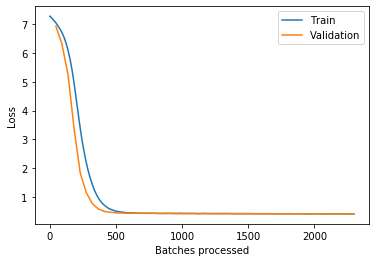

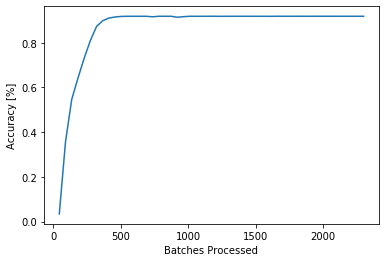

/home/can/anaconda3/envs/hqshift/lib/python3.6/site-packages/fastai/datasets.py:153: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  23


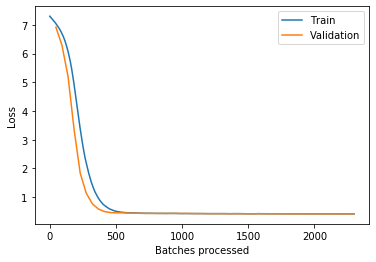

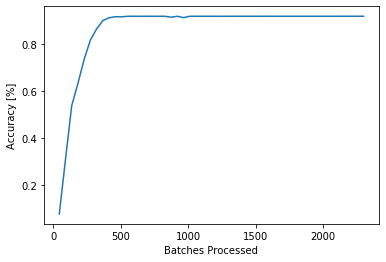

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  42


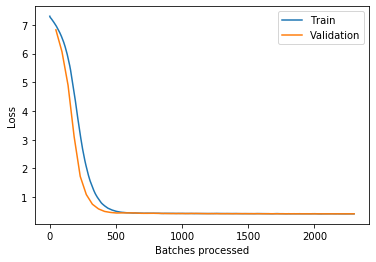

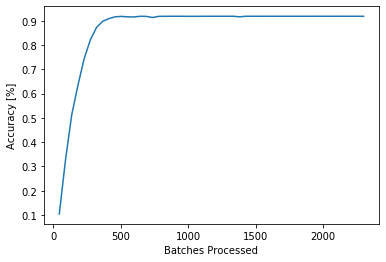

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  1234


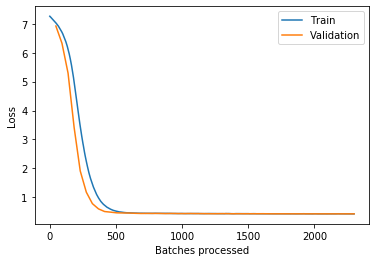

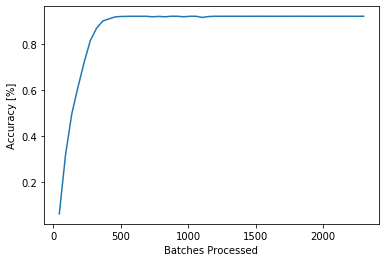

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  43210


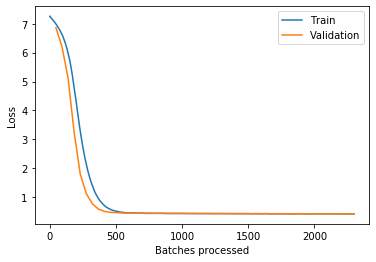

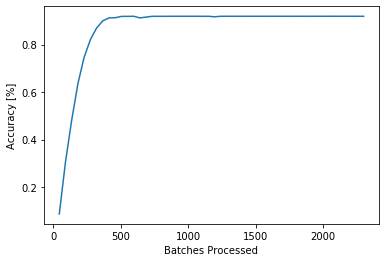

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  1133557799


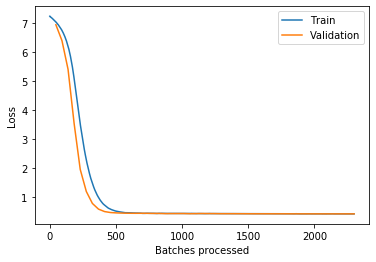

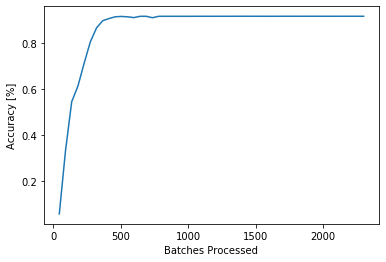

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  22446688


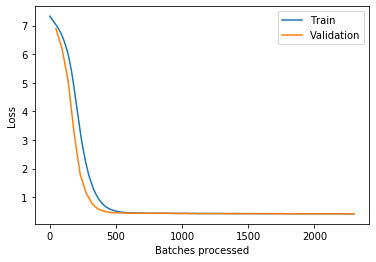

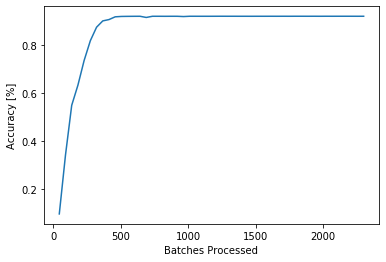

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  123456789


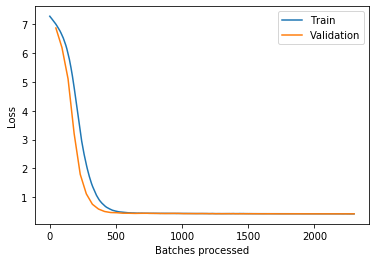

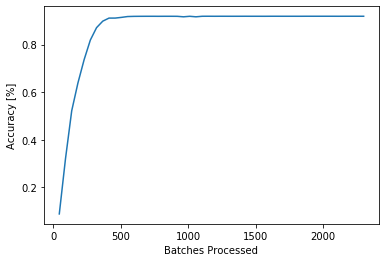

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  987654321


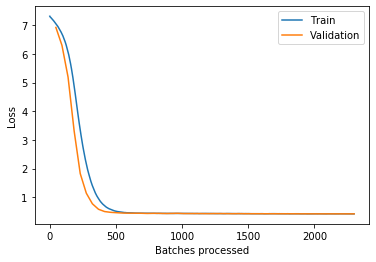

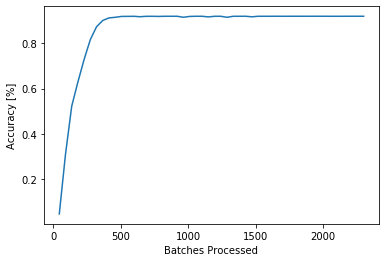

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  86420


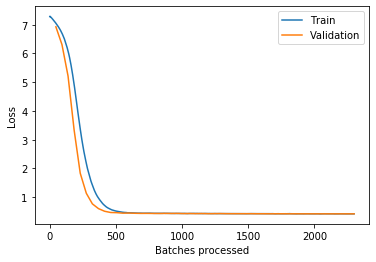

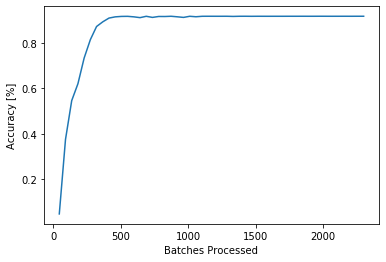

Paths:  3058 , Tokens:  1372
[36, 64, 181, 1003, 1063, 1335]
Adj. Rand Index Score: 0.951012.
Adj. Mutual Info Score: 0.909999.
Classes:  [0. 1.] n_clusters:  2.0


File Name to Train:  data_sets/00_bunch/glass/glass.csv
#############################################################
HDBSCAN
#############################################################
Adj. Rand Index Score: 0.283314.
Adj. Mutual Info Score: 0.402715.
Classes:  [-1  0  1  2  3  4  5  6] n_clusters:  7
QSHIFTPP
#############################################################
Adj. Rand Index Score: 0.333801.
Adj. Mutual Info Score: 0.441001.
Classes:  [0 1 2 3 4 5] n_clusters:  6
HQSHIFT
#############################################################
Adj. Rand Index Score: 0.286975.
Adj. Mutual Info Score: 0.402591.
Classes:  [-1  0  1  2  3  4  5  6] n_clusters:  7
Seed:  0


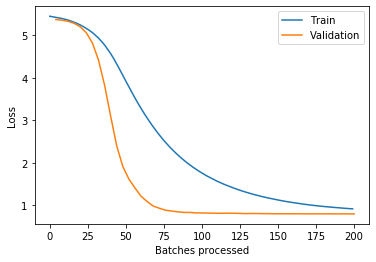

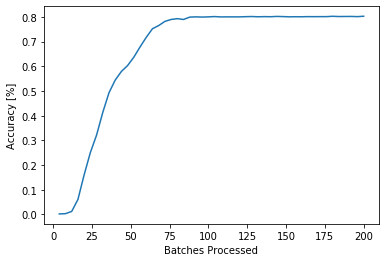

/home/can/anaconda3/envs/hqshift/lib/python3.6/site-packages/fastai/datasets.py:153: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  23


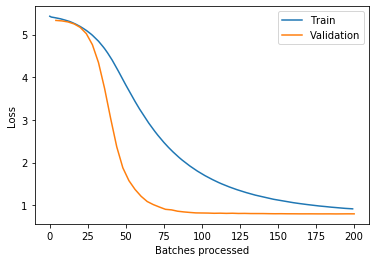

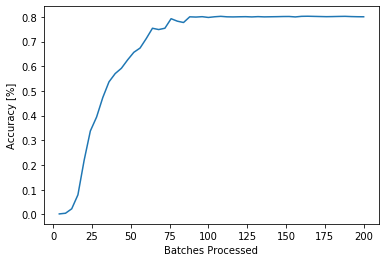

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  42


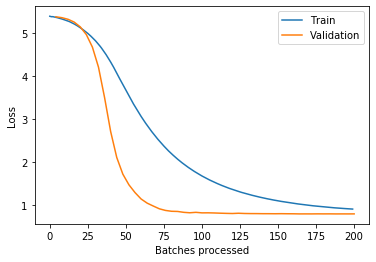

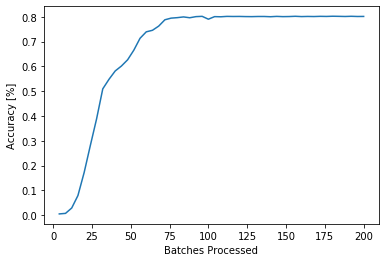

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  1234


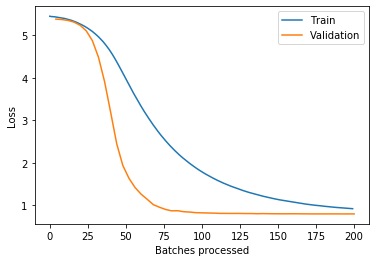

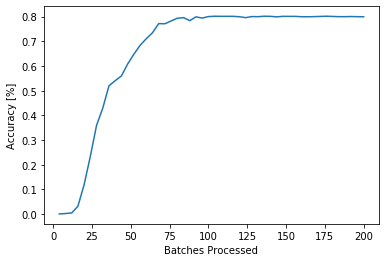

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  43210


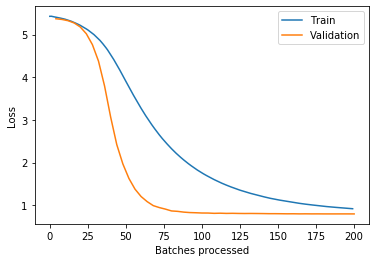

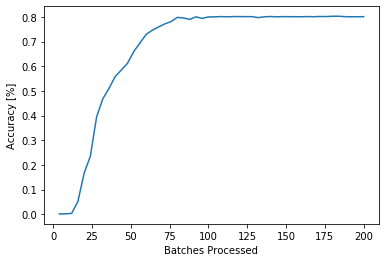

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  1133557799


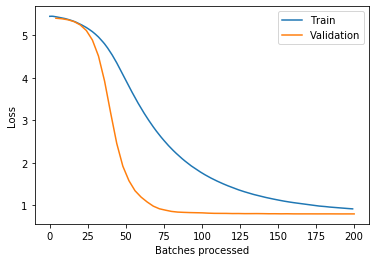

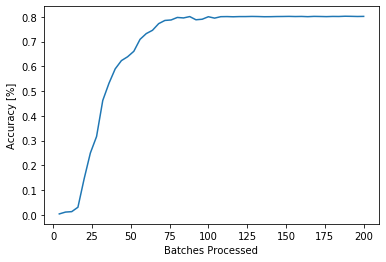

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  22446688


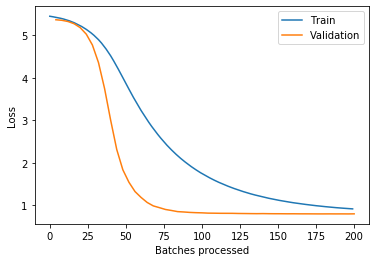

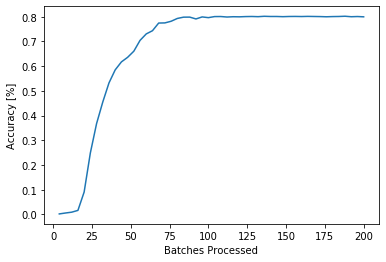

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  123456789


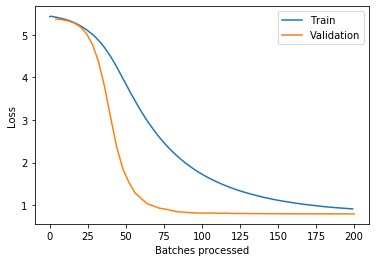

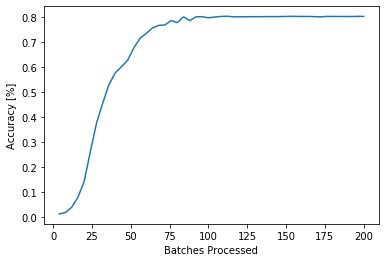

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  987654321


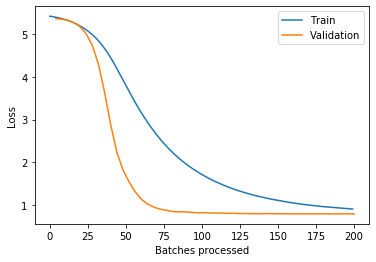

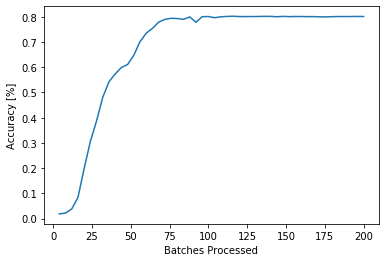

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0
Seed:  86420


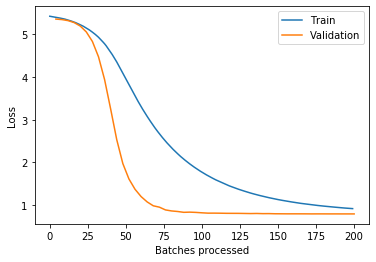

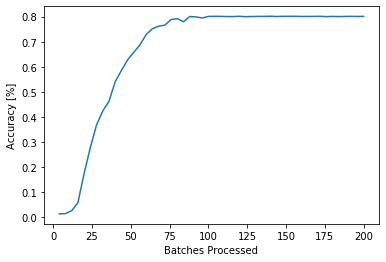

Paths:  567 , Tokens:  214
[30, 65, 91, 103, 131, 144, 161, 186, 205]
0
Adj. Rand Index Score: 0.294805.
Adj. Mutual Info Score: 0.394123.
Classes:  [0. 1. 2. 3. 4. 6.] n_clusters:  7.0


File Name to Train:  data_sets/00_bunch/iris/iris.csv
#############################################################
HDBSCAN
#############################################################
Adj. Rand Index Score: 0.539409.
Adj. Mutual Info Score: 0.547691.
Classes:  [-1  0  1] n_clusters:  2
QSHIFTPP
#############################################################
Adj. Rand Index Score: 0.568116.
Adj. Mutual Info Score: 0.576771.
Classes:  [0 1] n_clusters:  2
HQSHIFT
#############################################################
Adj. Rand Index Score: 0.568116.
Adj. Mutual Info Score: 0.576771.
Classes:  [0 1] n_clusters:  2
Seed:  0


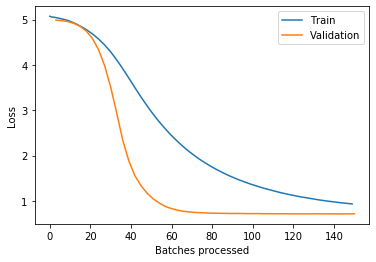

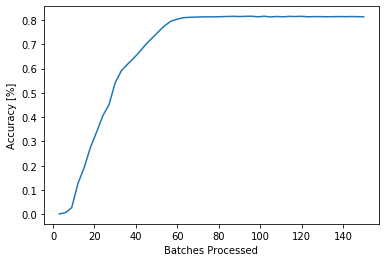

/home/can/anaconda3/envs/hqshift/lib/python3.6/site-packages/fastai/datasets.py:153: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  23


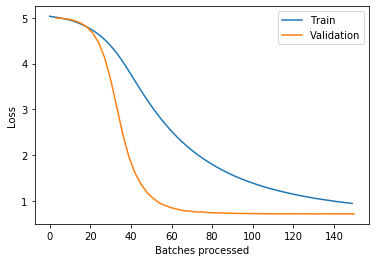

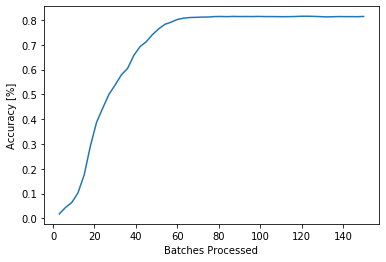

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  42


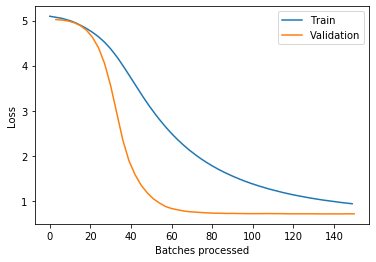

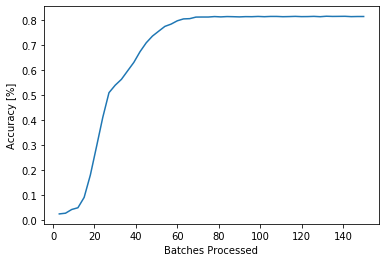

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  1234


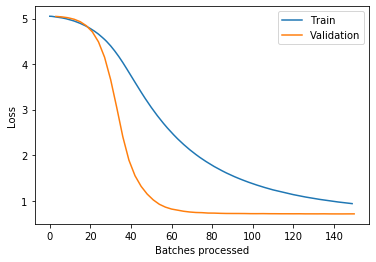

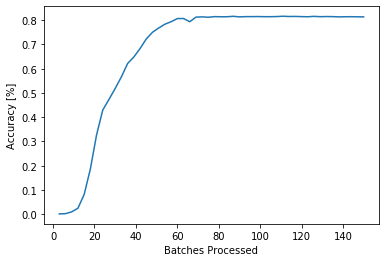

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  43210


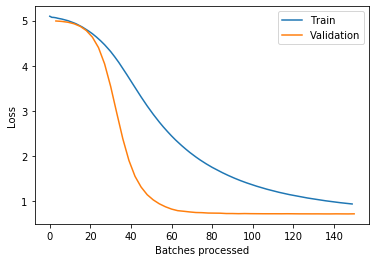

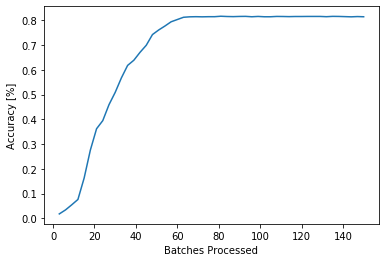

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  1133557799


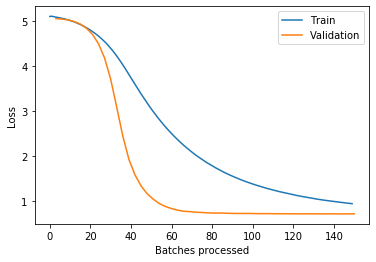

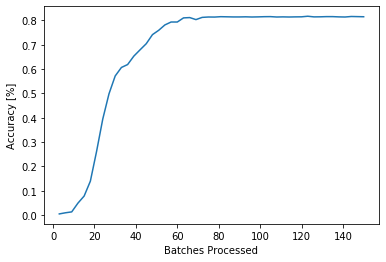

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  22446688


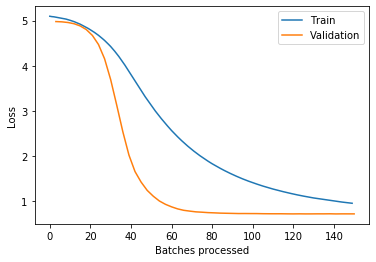

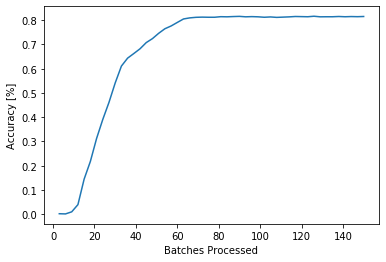

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  123456789


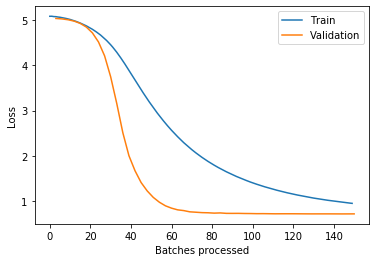

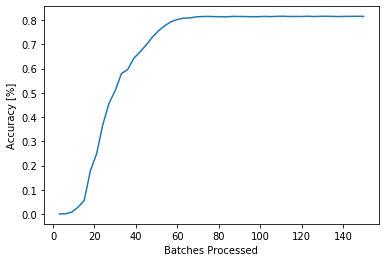

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  987654321


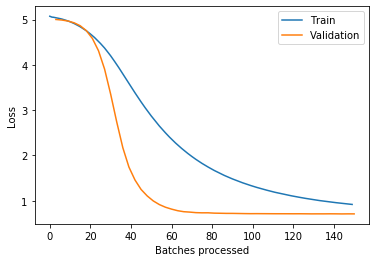

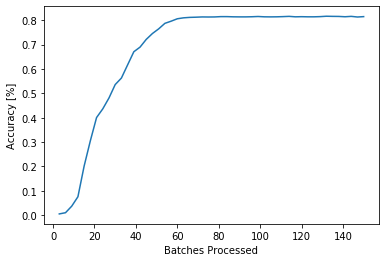

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0
Seed:  86420


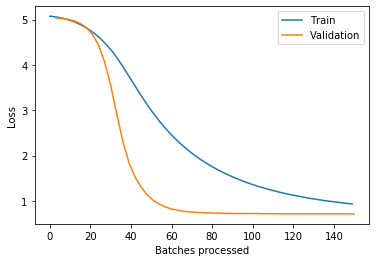

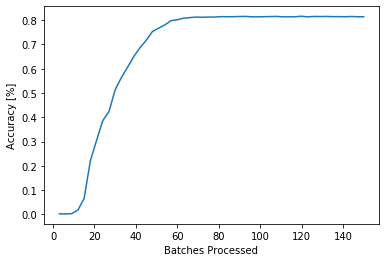

Paths:  318 , Tokens:  150
[8, 56, 79, 127]
0
Adj. Rand Index Score: 0.543752.
Adj. Mutual Info Score: 0.542515.
Classes:  [0. 1.] n_clusters:  2.0


File Name to Train:  data_sets/00_bunch/mnist/mnist.csv
#############################################################
HDBSCAN
#############################################################
Adj. Rand Index Score: 0.751959.
Adj. Mutual Info Score: 0.811806.
Classes:  [0 1 2 3 4 5 6 7 8] n_clusters:  9
QSHIFTPP
#############################################################
Adj. Rand Index Score: 0.815115.
Adj. Mutual Info Score: 0.838626.
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11] n_clusters:  12
HQSHIFT
#############################################################
Adj. Rand Index Score: 0.751959.
Adj. Mutual Info Score: 0.811806.
Classes:  [0 1 2 3 4 5 6 7 8] n_clusters:  9
Seed:  0


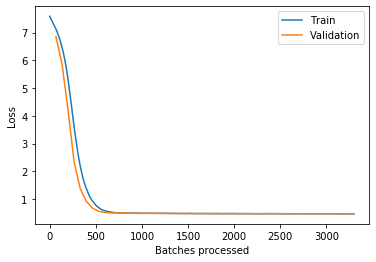

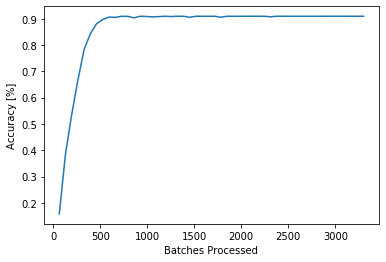

/home/can/anaconda3/envs/hqshift/lib/python3.6/site-packages/fastai/datasets.py:153: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
0
0
Adj. Rand Index Score: 0.770185.
Adj. Mutual Info Score: 0.826536.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  23


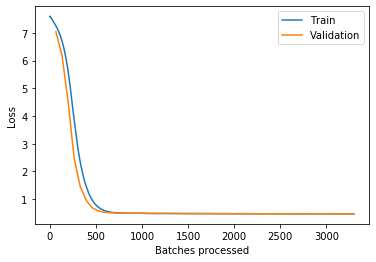

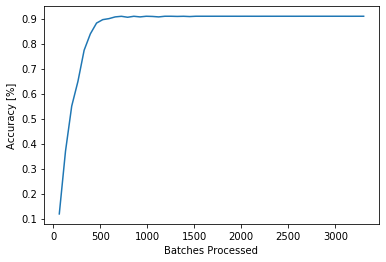

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
0
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  42


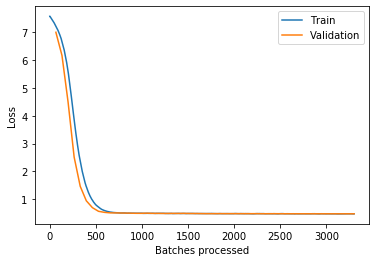

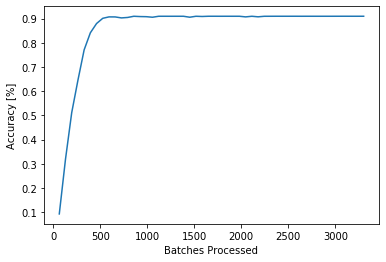

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  1234


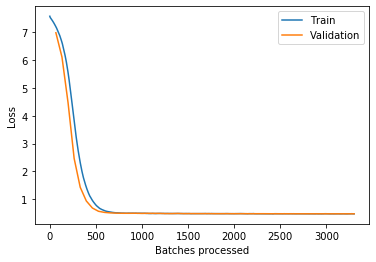

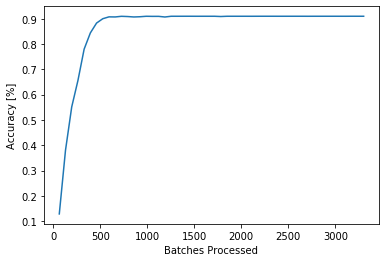

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
0
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  43210


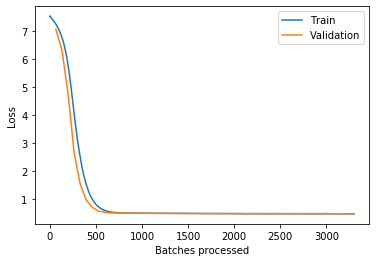

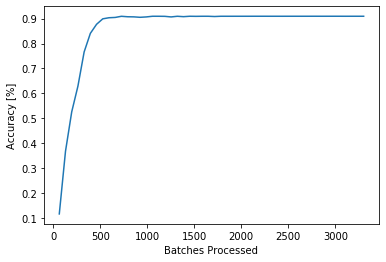

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  1133557799


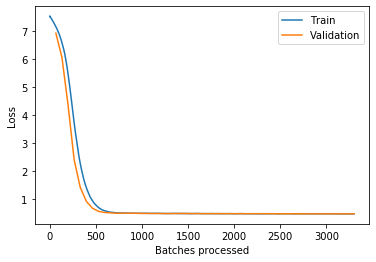

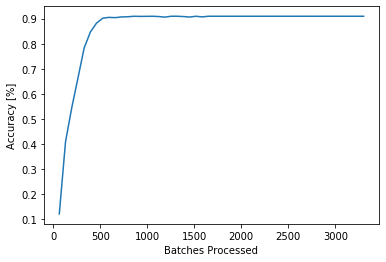

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  22446688


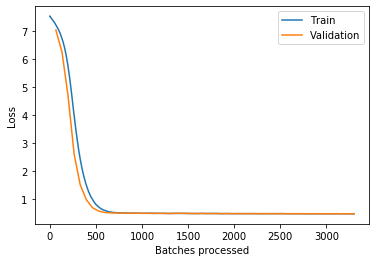

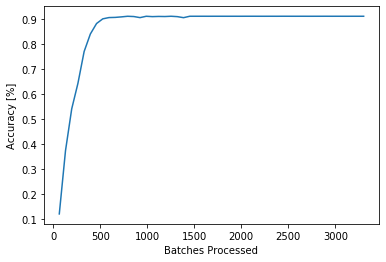

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  123456789


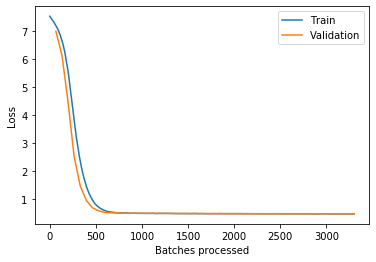

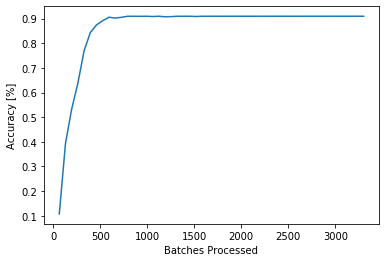

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  987654321


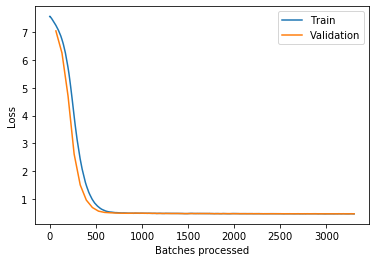

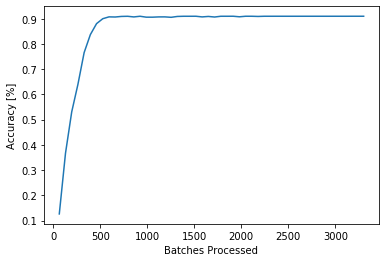

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0
Seed:  86420


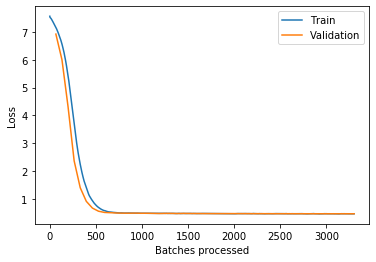

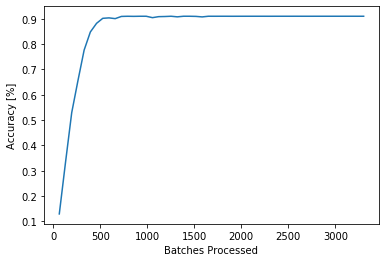

Paths:  4685 , Tokens:  1797
[167, 352, 1076, 1457, 1505, 1670, 1741, 1762, 1764]
Adj. Rand Index Score: 0.768024.
Adj. Mutual Info Score: 0.823528.
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8.] n_clusters:  9.0


File Name to Train:  data_sets/00_bunch/seeds/seeds.csv
#############################################################
HDBSCAN
#############################################################
Adj. Rand Index Score: 0.413773.
Adj. Mutual Info Score: 0.504953.
Classes:  [-1  0  1  2] n_clusters:  3
QSHIFTPP
#############################################################
Adj. Rand Index Score: 0.752283.
Adj. Mutual Info Score: 0.707126.
Classes:  [0 1 2] n_clusters:  3
HQSHIFT
#############################################################
Adj. Rand Index Score: 0.413773.
Adj. Mutual Info Score: 0.504953.
Classes:  [-1  0  1  2] n_clusters:  3
Seed:  0


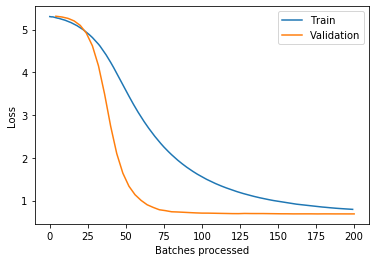

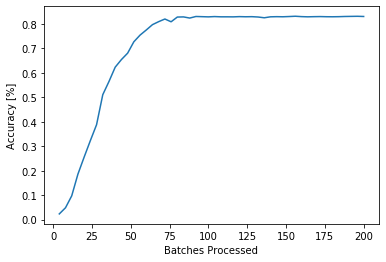

/home/can/anaconda3/envs/hqshift/lib/python3.6/site-packages/fastai/datasets.py:153: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  23


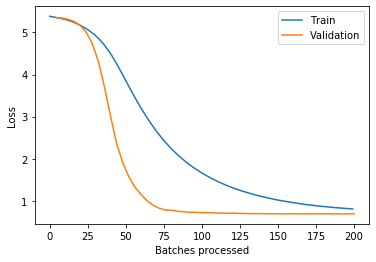

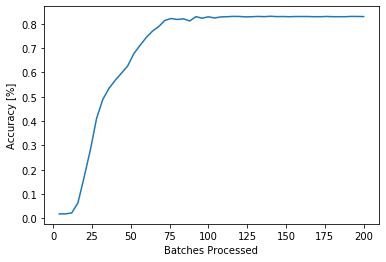

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  42


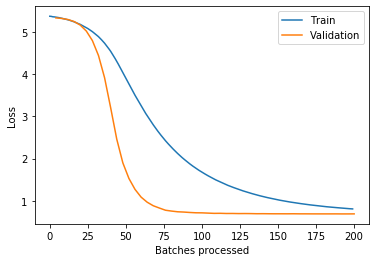

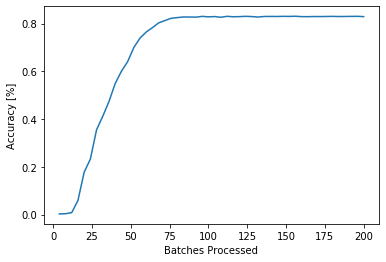

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  1234


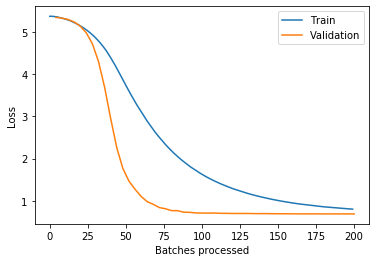

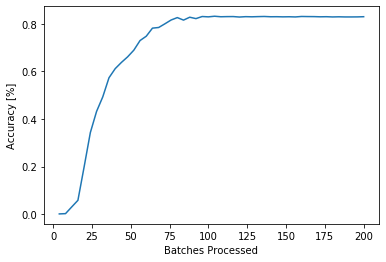

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  43210


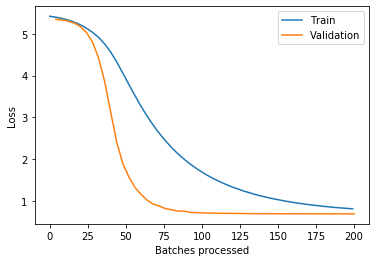

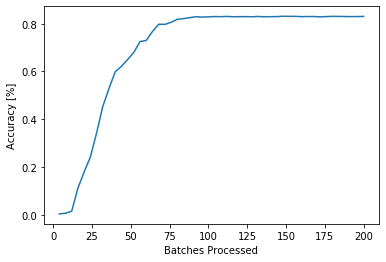

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  1133557799


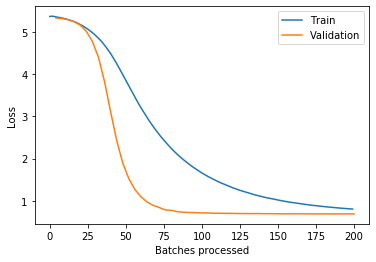

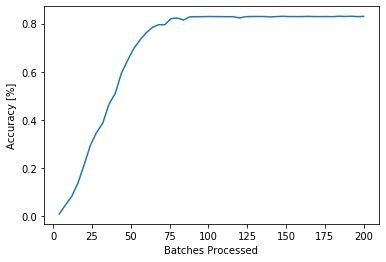

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  22446688


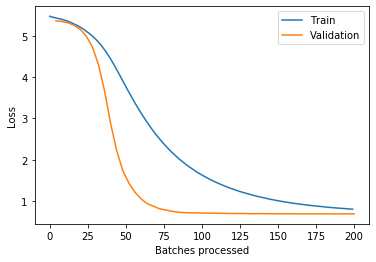

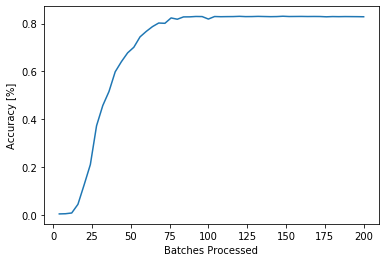

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  123456789


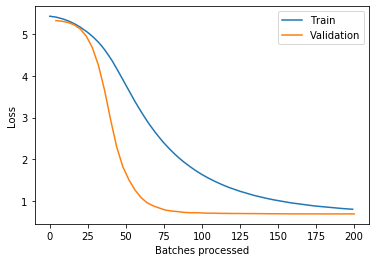

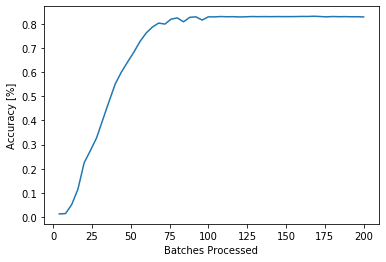

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  987654321


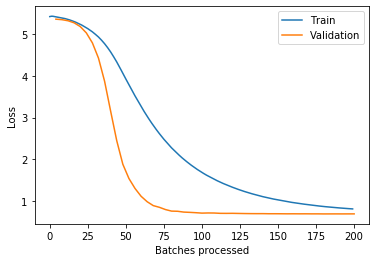

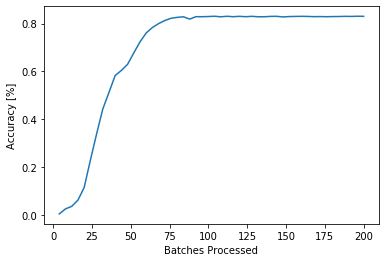

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0
Seed:  86420


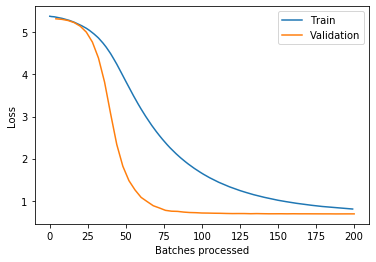

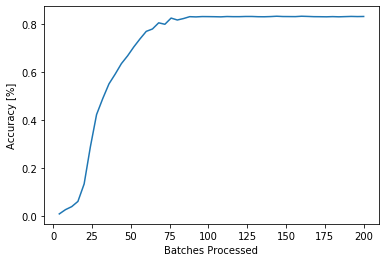

Paths:  474 , Tokens:  210
[49, 69, 93, 122, 183, 192]
0
Adj. Rand Index Score: 0.403137.
Adj. Mutual Info Score: 0.473262.
Classes:  [0. 1. 2.] n_clusters:  3.0


File Name to Train:  data_sets/01_bunch/phoneme/phoneme.csv
#############################################################
HDBSCAN
#############################################################
Adj. Rand Index Score: 0.760092.
Adj. Mutual Info Score: 0.779888.
Classes:  [0 1 2 3] n_clusters:  4
QSHIFTPP
#############################################################
Adj. Rand Index Score: 0.489517.
Adj. Mutual Info Score: 0.584644.
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10] n_clusters:  11
HQSHIFT
#############################################################
Adj. Rand Index Score: 0.760092.
Adj. Mutual Info Score: 0.779888.
Classes:  [0 1 2 3] n_clusters:  4
Seed:  0


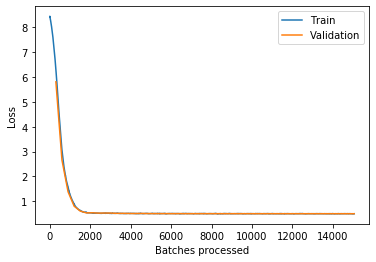

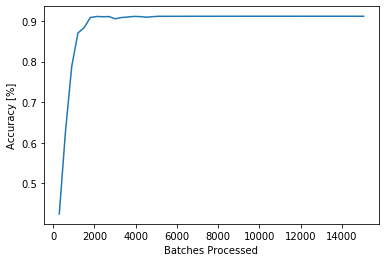

/home/can/anaconda3/envs/hqshift/lib/python3.6/site-packages/fastai/datasets.py:153: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  23


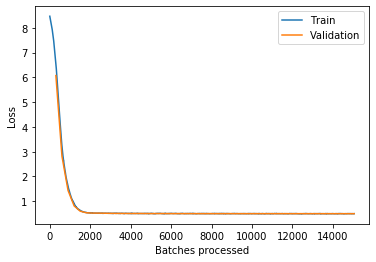

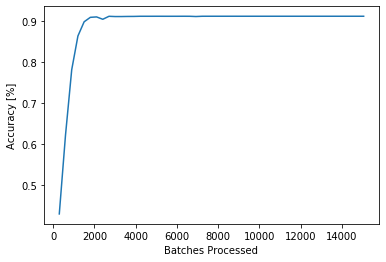

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  42


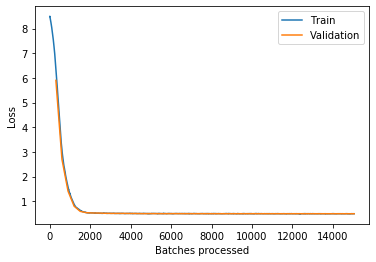

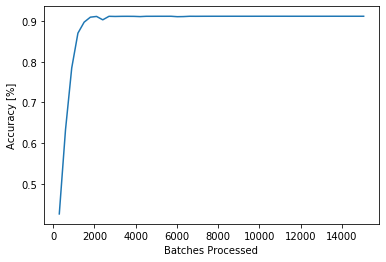

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  1234


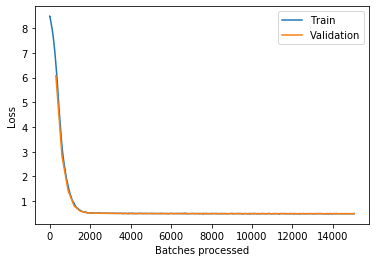

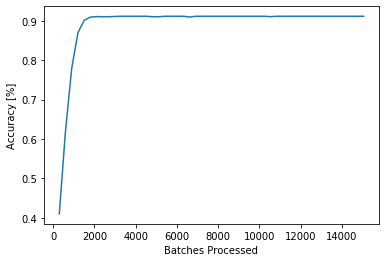

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  43210


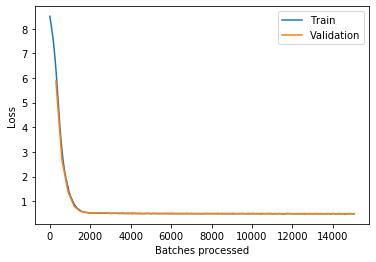

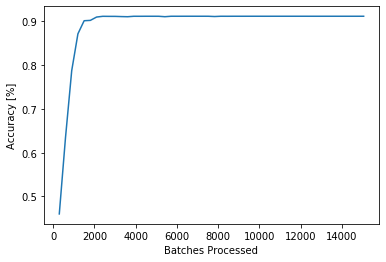

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  1133557799


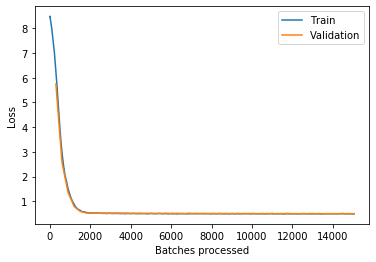

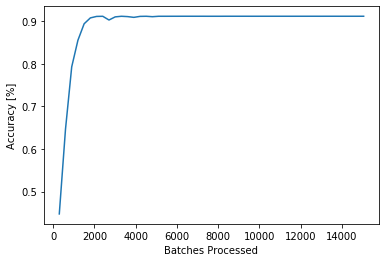

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
0
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  22446688


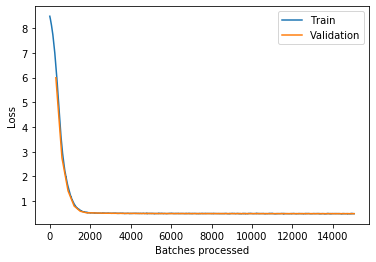

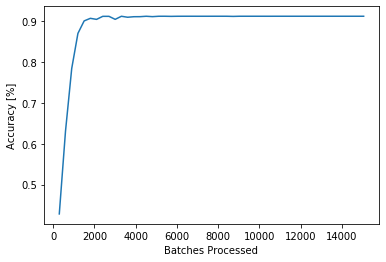

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  123456789


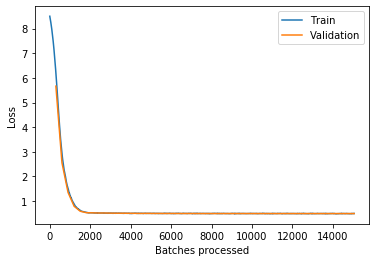

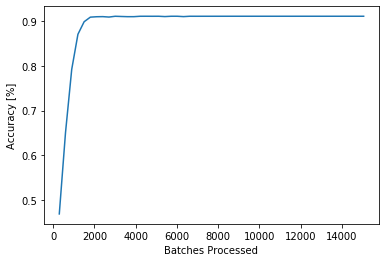

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
0
0
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  987654321


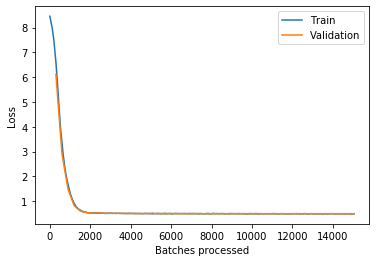

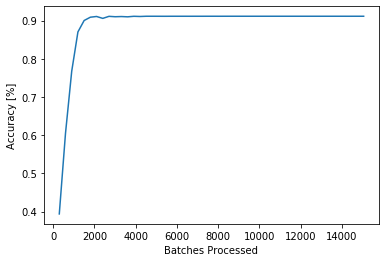

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0
Seed:  86420


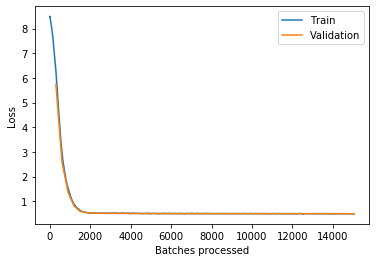

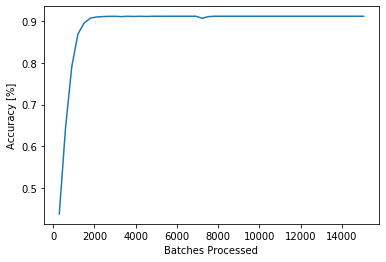

Paths:  19283 , Tokens:  4508
[108, 385, 419, 1116, 2174, 2396, 2751, 2869, 3200, 3409, 3724, 3890, 4023, 4174, 4374, 4411, 4425]
Adj. Rand Index Score: 0.758399.
Adj. Mutual Info Score: 0.777229.
Classes:  [0. 1. 2. 3.] n_clusters:  4.0


File Name to Train:  data_sets/02_bunch/page-blocks/page-blocks.csv
#############################################################
HDBSCAN
#############################################################
Adj. Rand Index Score: 0.577030.
Adj. Mutual Info Score: 0.354158.
Classes:  [-1  0  1] n_clusters:  2
QSHIFTPP
#############################################################
Adj. Rand Index Score: 0.027815.
Adj. Mutual Info Score: 0.089215.
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] n_clusters:  19
HQSHIFT
#############################################################
Adj. Rand Index Score: 0.577030.
Adj. Mutual Info Score: 0.354158.
Classes:  [-1  0  1] n_clusters:  2
Seed:  0


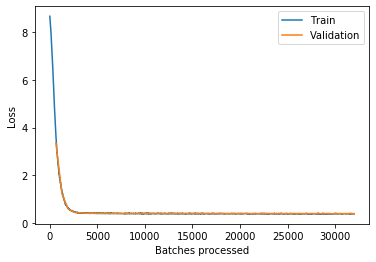

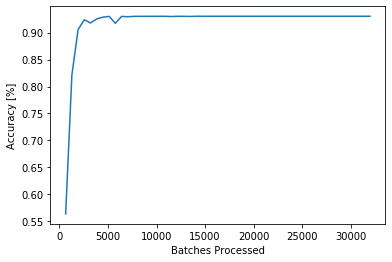

/home/can/anaconda3/envs/hqshift/lib/python3.6/site-packages/fastai/datasets.py:153: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
0
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  23


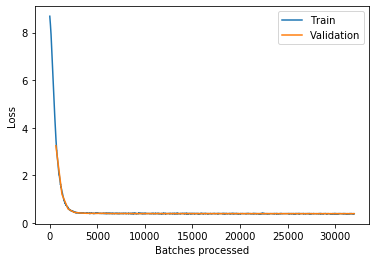

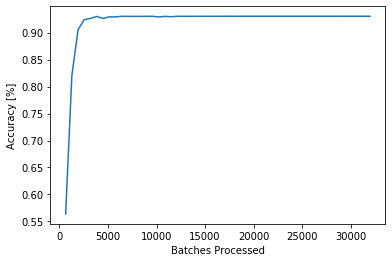

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
0
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  42


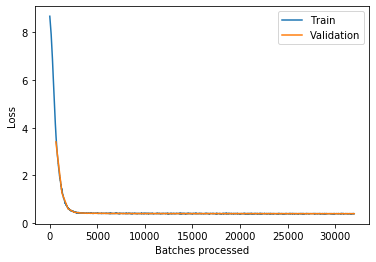

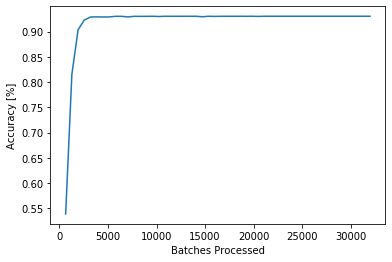

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
0
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  1234


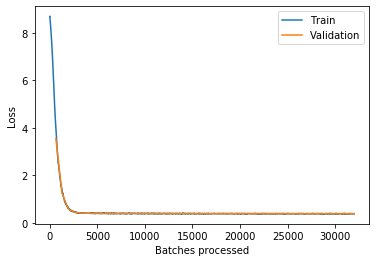

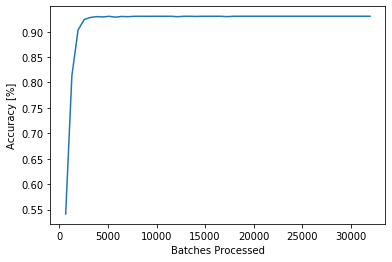

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  43210


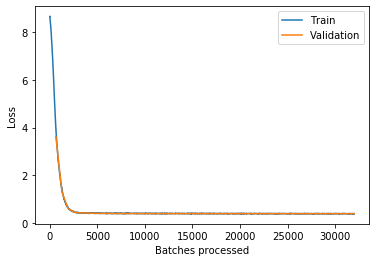

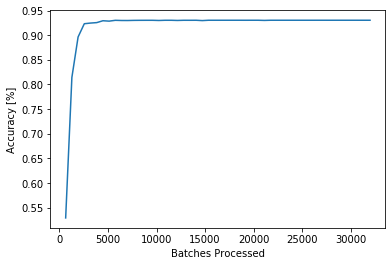

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  1133557799


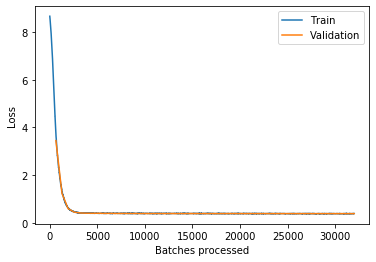

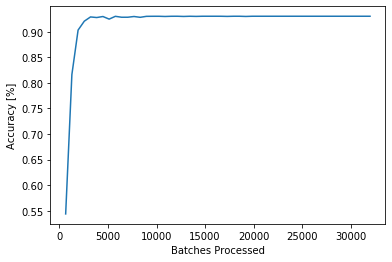

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  22446688


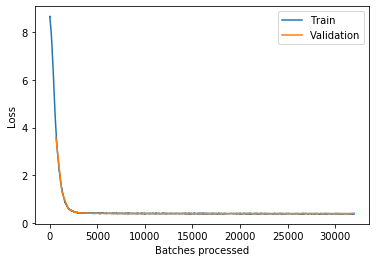

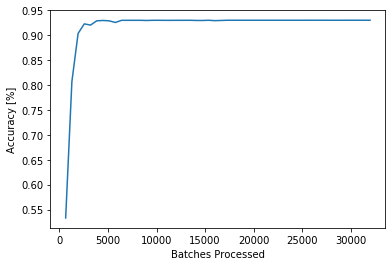

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  123456789


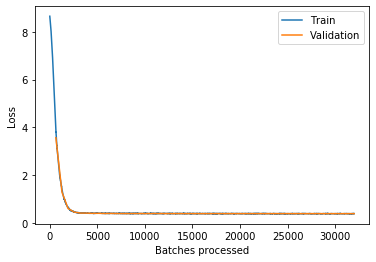

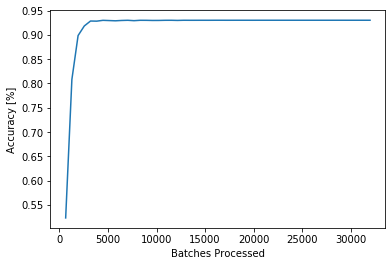

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
0
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  987654321


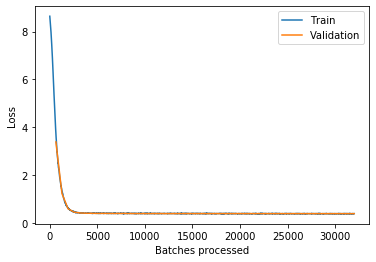

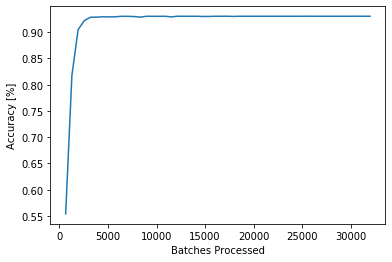

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0
Seed:  86420


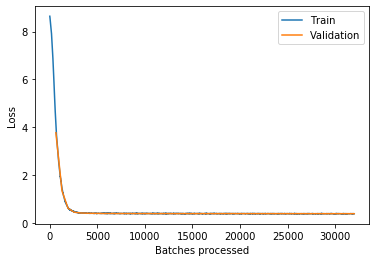

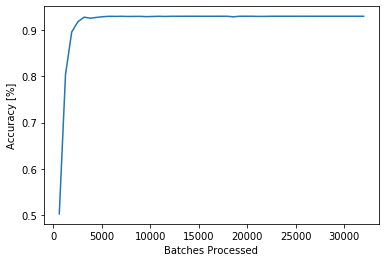

Paths:  31223 , Tokens:  5473
[172, 372, 527, 1718, 1828, 2132, 2229, 2312, 2424, 2454, 2462, 2633, 3129, 3159, 3276, 3356, 3417, 3637, 3692, 4288, 4772, 5216, 5364, 5384, 5463]
Adj. Rand Index Score: 0.569727.
Adj. Mutual Info Score: 0.300430.
Classes:  [-1.  0.  1.] n_clusters:  2.0


In [324]:
fileList2Train = ["data_sets/00_bunch/banknote/banknote.csv",
                  "data_sets/00_bunch/glass/glass.csv",
                  "data_sets/00_bunch/iris/iris.csv",
                  "data_sets/00_bunch/mnist/mnist.csv",
                  "data_sets/00_bunch/seeds/seeds.csv",
                  "data_sets/01_bunch/phoneme/phoneme.csv",
                  "data_sets/02_bunch/page-blocks/page-blocks.csv"]
datasets = ['banknote', 'glass', 'iris', 'mnist', 'seeds', 'phoneme', 'page-blocks']

# NN Settings
nh     = 32
bs     = 64
bptt   = 20
lr     = 1e-2
n_iter = 50

perf_output = []

class Model_Density(nn.Module):
    def __init__(self, nv, nh, bs):
        super().__init__()
        self.nv = nv
        self.nh = nh
        self.bs = bs
        self.i_h = nn.Embedding(self.nv,self.nh)
        self.rnn = nn.GRU(self.nh, self.nh, 2, batch_first=True)
        self.h_o = nn.Linear(self.nh, self.nv)
        self.bn = BatchNorm1dFlat(self.nh)
        self.reset()
    def reset(self):
        self.h = torch.zeros(2, self.bs, self.nh).cuda()  
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

for ifn, fn2T in enumerate(fileList2Train):
    print('\n\nFile Name to Train: ', fn2T)
    print('#############################################################')
    data0 = pd.read_csv(fn2T, header=None)
    X = data0.iloc[:,:-1].values
    y = data0.iloc[:, -1].values
    if X.shape[1] > 4: 
        X = umap.UMAP(
            n_neighbors=50,
            min_dist=0.0,
            n_components=4,
            random_state=seed,
        ).fit_transform(X)
        
    #parameter definition
    best_min_cluster_size = 17
    if X.shape[0] > 1000:
        best_min_cluster_size = 125
    best_min_sample_size = 3
    best_min_mode_size = best_min_cluster_size
    
    # HDBSCAN
    print('HDBSCAN')
    print('#############################################################')
    clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_sample_size)
    y_hat = clusterer.fit_predict(X)
    print("Adj. Rand Index Score: %f." % adjusted_rand_score(y_hat, y))
    print("Adj. Mutual Info Score: %f." % adjusted_mutual_info_score(y_hat, y))
    print('Classes: ', np.unique(y_hat), 'n_clusters: ', np.unique(y_hat)[-1]+1)
    perf_output.append((adjusted_rand_score(y_hat, y), adjusted_mutual_info_score(y_hat, y)))
    # QSHIFTPP
    print('QSHIFTPP')
    print('#############################################################')
    X_qspp = X.copy(order='C')
    k=25
    if X.shape [0] > 1000:
        k = 60
    model = QuickshiftPP(k=k, beta=.6)
    # Compute the clustering.
    model.fit(X_qspp)
    y_hat = model.memberships
    print("Adj. Rand Index Score: %f." % adjusted_rand_score(y_hat, y))
    print("Adj. Mutual Info Score: %f." % adjusted_mutual_info_score(y_hat, y))
    print('Classes: ', np.unique(y_hat), 'n_clusters: ', np.unique(y_hat)[-1]+1)
    perf_output.append((adjusted_rand_score(y_hat, y), adjusted_mutual_info_score(y_hat, y)))
    
    #generate paths for RNN with HQSHIFT
    print('HQSHIFT')
    print('#############################################################')
    hqshift = HQSHIFT(min_cluster_size=best_min_cluster_size,
                      min_mode_size=best_min_mode_size,
                      min_samples=best_min_sample_size,
                      allow_single_cluster=False).fit(X)
    # cluster labels
    y_hat = hqshift.labels_
    print("Adj. Rand Index Score: %f." % adjusted_rand_score(y_hat, y))
    print("Adj. Mutual Info Score: %f." % adjusted_mutual_info_score(y_hat, y))
    print('Classes: ', np.unique(y_hat), 'n_clusters: ', np.unique(y_hat)[-1]+1)
    
    
    clust_paths = [[j]+pth[:pth.index(idx)+1] for idx in hqshift._idx_root 
                                              for j, pth in enumerate(hqshift.paths) if idx in pth]
    clust_data = [X[pth] for pth in clust_paths] 
    # Construct Vocabulary, make sure BOS (<xxbos>) idx is 0
    vocab_tok = [BOS] + [str(idx) for idx in np.arange(X.shape[0])]
    # => ['<pad>', '0', '1', '2', '3',... 'seq_len-1']
    vocab_ = {idx:tok for idx,tok in enumerate(vocab_tok)}
    ids = [[0]+list(np.array(pth)+1) for pth in clust_paths]
    vocab=Vocab(vocab_)
    nv = len(vocab.itos)
    ids = np.array(ids)
    data = TextLMDataBunch.from_ids('/tmp', vocab=vocab,
                                    train_ids=ids, valid_ids=ids,
                                    bs=bs, bptt=bptt, device=device)
    for inet in range(0, 10):
        #Learner
        random_seed(seed_value=seed_lst[inet], use_cuda=use_cuda)
        print('Seed: ', seed_lst[inet])
        learn = Learner(data, Model_Density(nv, nh, bs), metrics=accuracy)
        learn.fit_one_cycle(n_iter, lr);
        learn.recorder.plot_losses()
        plt.show()
        learn.recorder.plot_metrics()
        plt.xlabel('Batches Processed')
        plt.ylabel('Accuracy [%]')
        plt.show()
        learn.save(datapath4file(str(URLs.LOCAL_PATH/'models')+'/'+datasets[ifn]+'%02d'%inet), return_path=True)
        print('Paths: ', len(learn.data.train_ds), ', Tokens: ', X.shape[0])
        stop_cond = sorted([ridx+1 for ridx in hqshift._idx_root])
        print(stop_cond)
        # calculate cluster validation scores with trained RNN
        y_hat = -2*np.ones(X.shape[0])
        for q_p in range(X.shape[0]):
            m = learn.model
            #set batch size to 1
            learn.model.bs=1
            #turn off dropout
            m.eval()
            #reset hidden state
            m.reset()
            idxs = np.array([0, q_p+1])
            idxs = torch.tensor(idxs, device=device)

    #         import pdb; pdb.set_trace()
            for _ in range(bptt):
                p = m.forward(idxs[None,:])
                cls = F.softmax(p[0], dim=1).argmax(dim=1)
                if cls[-1].item()==0: print(0); break
                idxs = torch.cat((idxs, cls[-1].unsqueeze(0)))
                if cls[-1].item() in stop_cond: break
    #             import pdb;pdb.set_trace()
            #set the class label from the last index of the trajectory produced by HQuickShift
            y_hat[q_p] = hqshift.labels_[idxs[-1]-1] 
    #         print(q_p, y_hat[q_p])

        print("Adj. Rand Index Score: %f." % adjusted_rand_score(y_hat, y))
        print("Adj. Mutual Info Score: %f." % adjusted_mutual_info_score(y_hat, y))
        perf_output.append((adjusted_rand_score(y_hat, y), adjusted_mutual_info_score(y_hat, y)))
        print('Classes: ', np.unique(y_hat), 'n_clusters: ', np.unique(y_hat)[-1]+1)

In [325]:
perf_output

[(0.7921222771673334, 0.6256005245618719),
 (0.6901459877245661, 0.55538929616125),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.9510116641908538, 0.9099986699927317),
 (0.2833139524710691, 0.40271481855442615),
 (0.333800696792064, 0.44100083357096465),
 (0.29480471723393786, 0.3941229139711741),
 (0.29480471723393786, 0.3941229139711741),
 (0.29480471723393786, 0.3941229139711741),
 (0.29480471723393786, 0.3941229139711741),
 (0.29480471723393786, 0.3941229139711741),
 (0.29480471723393786, 0.3941229139711741),
 (0.29480471723393786, 0.3941229139711741),
 (0.29480471723393786, 0.3941229139711741),
 (0.29480471723393786, 0.3941229139711741),
 (0

In [326]:
import json
with open('perf_out.txt', 'w') as filehandle:  
    json.dump(perf_output, filehandle)

### Exploratory Data Analysis

Some exploratory data analysis to inspect the dimensionality reduction techniques:

In [254]:
#data0 = pd.read_csv("data_sets/00_bunch/banknote/banknote.csv", header=None)
#data0 = pd.read_csv("data_sets/00_bunch/glass/glass.csv", header=None)
#data0 = pd.read_csv("data_sets/00_bunch/iris/iris.csv", header=None)
#data0 = pd.read_csv("data_sets/00_bunch/mnist/mnist.csv", header=None)
data0 = pd.read_csv("data_sets/00_bunch/seeds/seeds.csv", header=None)
#data0 = pd.read_csv("data_sets/01_bunch/phoneme/phoneme.csv", header=None)
#data0 = pd.read_csv("data_sets/02_bunch/page-blocks/page-blocks.csv", header=None)

X = data0.iloc[:,:-1].values
y = data0.iloc[:, -1].values
X.shape, y.shape

((210, 7), (210,))

In [137]:
pca_trans = PCA(n_components=4).fit(X)
clusterable_embedding = pca_trans.transform(X)

In [134]:
np.sum(pca_trans.explained_variance_ratio_)

0.7719867961314373

In [255]:
import umap
clusterable_embedding = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=4,
    random_state=0,
).fit_transform(X)

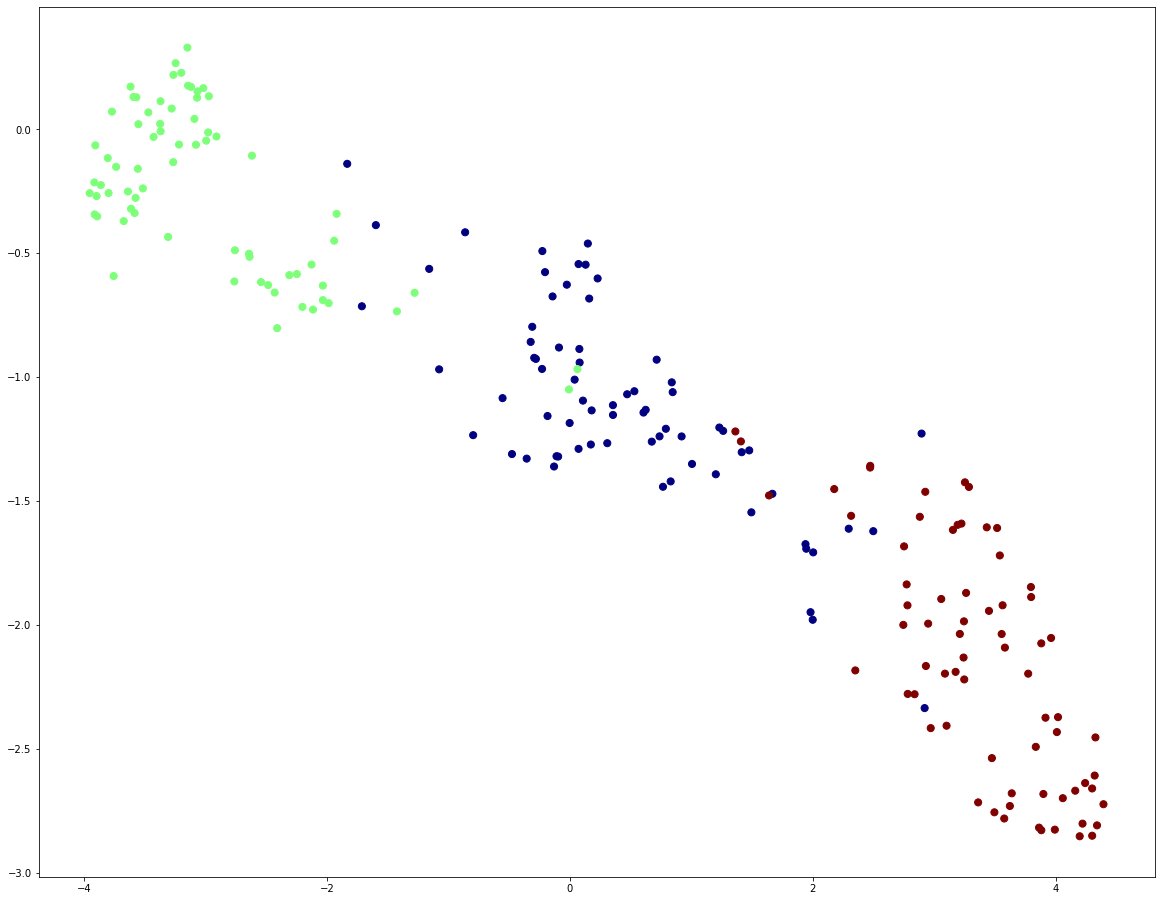

In [256]:
#clusterable_embedding = X
plt.figure(figsize=fig_size)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=y, s=50, cmap='jet');

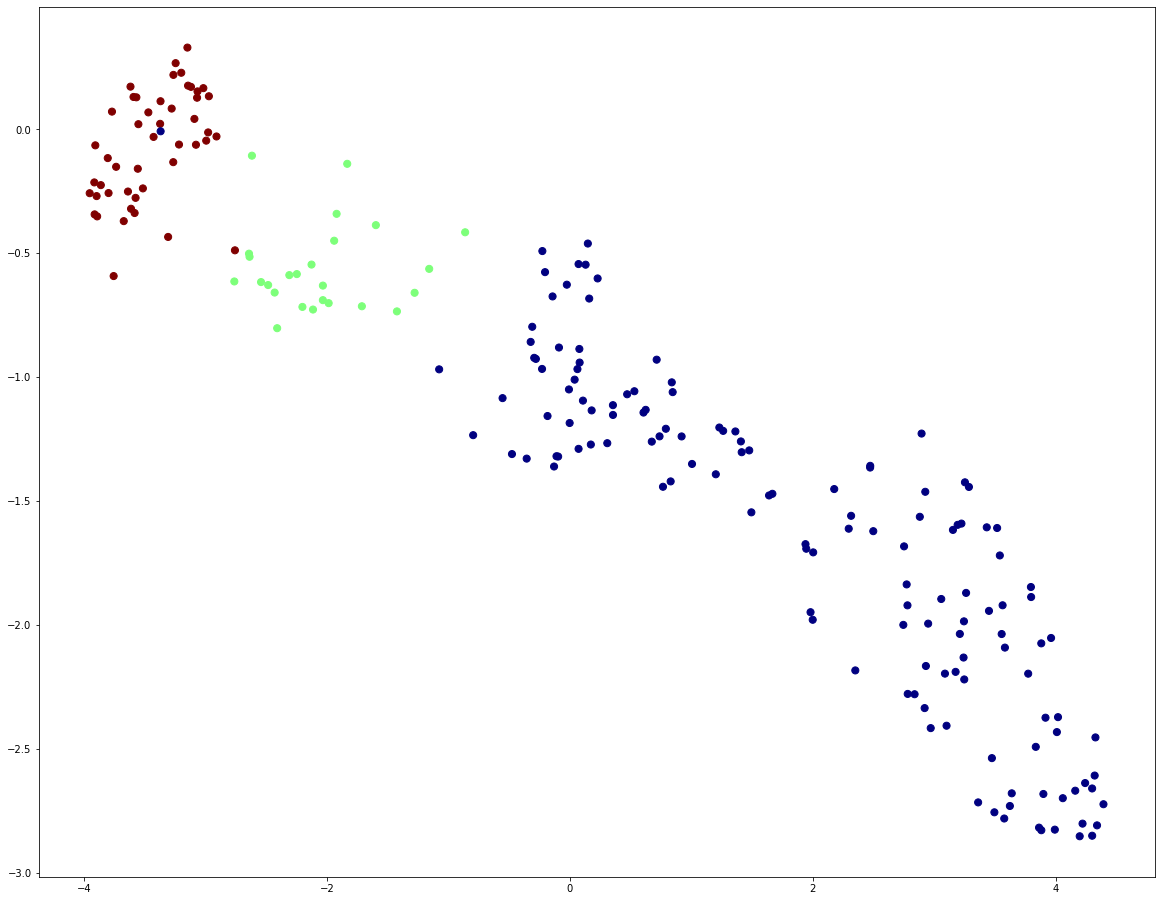

In [257]:
#clusterable_embedding = X
plt.figure(figsize=fig_size)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=y_hat, s=50, cmap='jet');